In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import cross_validate

!pip install xgboost
import xgboost as xgb


  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)


In [2]:
!pip install --user PyALE
import PyALE
from PyALE import ale

In [3]:
df=pd.read_csv('/home/jupyter/churn&cluster_v2_04_02.csv')

In [4]:
df=df.drop("Unnamed: 0", axis=1)
df.dropna(subset = ['churn'],inplace = True)

In [5]:
cluster=len(df.cluster.unique())
cluster

8

In [6]:
# Create 8 separate dataframes based on the cluster column
df_list = [df[df['cluster']==i] for i in range(cluster)]

# Assign separate dataframes to variables
df_cluster0, df_cluster1, df_cluster2, df_cluster3, df_cluster4, df_cluster5, df_cluster6, df_cluster7 = df_list

In [7]:
columns=['churn','avg_time_btw_orders', 'recency', 'months_elapsed',
       'purchase_times', 'lifetime_spent', 'lifetime_quantity',
       'per_order_spent', 'per_order_quantity', 'distinct_category_count',
       'discount_frequency_order', 'discount_frequency_product',
       'outdoor_equipment_pct', 'cargo_pct', 'soft_cooler_pct', 'bags_pct',
       'drinkware_pct', 'hard_cooler_pct', 'other_pct', 'black_pct',
       'white_pct', 'navy_pct', 'seaform_pct', 'stainless_pct', 'charcoal_pct',
       'nordic_purple_pct', 'harvest_red_pct', 'alpine_yellow_pct',
       'other_color_pct', 'product_added_count',
       'product_added_to_wishlist_count', 'product_removed_count',
       'customizer_started_count', 'customizer_completed_count',
       'cart_viewed_count', 'checkout_started_count', 'order_cancelled_count',
       'email_received', 'email_open_rate', 'max_entry_product_price',
       'unsubscribed_0.0', 'unsubscribed_1.0', 'unsubscribed_2.0']

for i in range(0,8):
    df = globals()['df_cluster{}'.format(i)]
    new_df = df[columns]
    globals()['df_cluster_short{}'.format(i)] = new_df

In [ ]:
count_df=pd.DataFrame(columns=["Cluster","No-Churn","Churn"])
for i in range(0, 8):
    df_target = globals()['df_cluster_short{}'.format(i)]
    nc = (df_target.churn.value_counts()[0]).astype(int)
    c = (df_target.churn.value_counts()[1]).astype(int)
    count_df.loc[i]=[i,nc,c]

In [ ]:
count_df["Total"]=(count_df["No-Churn"]+count_df.Churn)
count_df["Churn percentage"]=count_df.Churn/(count_df.Total)
count_df

Cluster No-Churn   Churn   Total Churn percentage
0       0    44945   30874   75819         0.407207
1       1    39773   55005   94778         0.580356
2       2   166530  251700  418230         0.601822
3       3    35404   41361   76765           0.5388
4       4   239910  315842  555752         0.568315
5       5    13134   16768   29902         0.560765
6       6   123100  127562  250662           0.5089
7       7     6837    7453   14290         0.521554

##### Skip : Normalization for every cluster. (Including recency/frequency)

Nor_columns=['avg_time_btw_orders', 'recency', 'months_elapsed',
       'purchase_times', 'lifetime_spent', 'lifetime_quantity',
       'per_order_spent', 'per_order_quantity', 'distinct_category_count',
       'discount_frequency_order', 'discount_frequency_product',
       'outdoor_equipment_pct', 'cargo_pct', 'soft_cooler_pct', 'bags_pct',
       'drinkware_pct', 'hard_cooler_pct', 'other_pct', 'black_pct',
       'white_pct', 'navy_pct', 'seaform_pct', 'stainless_pct', 'charcoal_pct',
       'nordic_purple_pct', 'harvest_red_pct', 'alpine_yellow_pct',
       'other_color_pct', 'product_added_count',
       'product_added_to_wishlist_count', 'product_removed_count',
       'customizer_started_count', 'customizer_completed_count',
       'cart_viewed_count', 'checkout_started_count', 'order_cancelled_count',
       'email_received', 'email_open_rate', 'max_entry_product_price',
       'unsubscribed_0.0', 'unsubscribed_1.0', 'unsubscribed_2.0']

for i in range(0, 8):
    df = globals()['df_cluster{}'.format(i)]  # Get the current dataframe
    churn_column = df['churn']  # Extract the "churn" column
    MinMaxScaler = preprocessing.MinMaxScaler()
    df[Nor_columns]= MinMaxScaler.fit_transform(df[Nor_columns])
 
    new_df = pd.concat([df[Nor_columns], churn_column], axis=1)
    globals()['scaled_df{}'.format(i)] = new_df  # Save the new dataframe as a global variable with a unique name

#### According to the grid tuning results. 
* Learning rate of 0.5 and Estimators of 150 give us the most efficient computation time and acceptable accuracy.
* Max_depth = 2 gives us more equally feature importance and slightly bit higher accuracy. (It does increase computation time)


In [ ]:

# create an empty dataframe to store the computation time
Xgb_time=pd.DataFrame(columns=["Cluster","Time"])

# create an empty dataframe to store the feature importance scores
feature_importance_df = pd.DataFrame(columns=['Cluster', 'Feature', 'Importance'])

for i in range(0, 8):
    start_time = time.time() # Start the timer
    df_ada = globals()['df_cluster_short{}'.format(i)]
    df_ada=df_ada.drop(['avg_time_btw_orders', 'recency'],axis=1)

    y_data=df_ada.churn
    x_data=df_ada.drop(['churn'],axis=1)
    
    #noise = np.random.rand(len(x_data), 1)

    # concatenate the noise array with your feature matrix
    #x_data = np.concatenate((x_data, noise), axis=1)

    
    
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state = 42
                                                       )
    
    Xgb_clf = xgb.XGBClassifier(max_depth=2,n_estimators=150,learning_rate=0.5)
    
    
    # Cross-validation
    #cv_results = cross_validate(Ada_clf, X_train, y_train, cv=5, scoring='accuracy')
    #cv_accuracy = cv_results['test_score']
    #print("cluster {}'s Cross Validation Accuracy:".format(i), cv_accuracy.mean())
    
    
    Xgb_clf.fit(X_train, y_train)
    
    ypred=Xgb_clf.predict(X_test) #These are the predicted output values
    
    # Get the feature importance scores for testing sets!!!!
    feature_importances = Xgb_clf.feature_importances_

    # add the feature importance scores to the dataframe
    for j in range(len(feature_importances)):
        feature_importance_df = feature_importance_df.append({'Cluster': i, 'Feature': x_data.columns[j], 'Importance': feature_importances[j]}, ignore_index=True)
    
    
    result = confusion_matrix(y_test, ypred)
    end_time = time.time() # End the timer
    print("cluster {}'s Confusion Matrix:".format(i))
    print(result)

    result1 = classification_report(y_test, ypred)
    print("cluster {}'s Classification Report:".format(i))
    print (result1)

    result2 = accuracy_score(y_test,ypred)
    print("cluster {}'s Accuracy:".format(i),result2,"\n")
    

    time_lapse=end_time - start_time
    Xgb_time.loc[i]=[i,time_lapse]

    print("cluster {}'s Computation Time:".format(i),time_lapse, "\n") # Print the computation time
    

cluster 0's Confusion Matrix:
[[7365 1628]
 [1990 4181]]
cluster 0's Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80      8993
         1.0       0.72      0.68      0.70      6171

    accuracy                           0.76     15164
   macro avg       0.75      0.75      0.75     15164
weighted avg       0.76      0.76      0.76     15164

cluster 0's Accuracy: 0.7614085993141652 

cluster 0's Computation Time: 30.797518968582153 

cluster 1's Confusion Matrix:
[[5386 2552]
 [1376 9642]]
cluster 1's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.73      7938
         1.0       0.79      0.88      0.83     11018

    accuracy                           0.79     18956
   macro avg       0.79      0.78      0.78     18956
weighted avg       0.79      0.79      0.79     18956

cluster 1's Accuracy: 0.7927832876134205 

cluster 1's Computation T

In [ ]:
# pivot the feature_importance_df dataframe to a wide format
feature_importance_wide = feature_importance_df.pivot(index='Cluster', columns='Feature', values='Importance')
f_sort=feature_importance_wide.T
f_sort["Average"]=(feature_importance_wide.T[0]+feature_importance_wide.T[7]+feature_importance_wide.T[1]+feature_importance_wide.T[2]
                                    +feature_importance_wide.T[3]+feature_importance_wide.T[4]+feature_importance_wide.T[5]+feature_importance_wide.T[6])/7
f_sort=f_sort.sort_values("Average",ascending=False)

f_sort.style.format("{:.2f}").background_gradient(cmap='coolwarm')

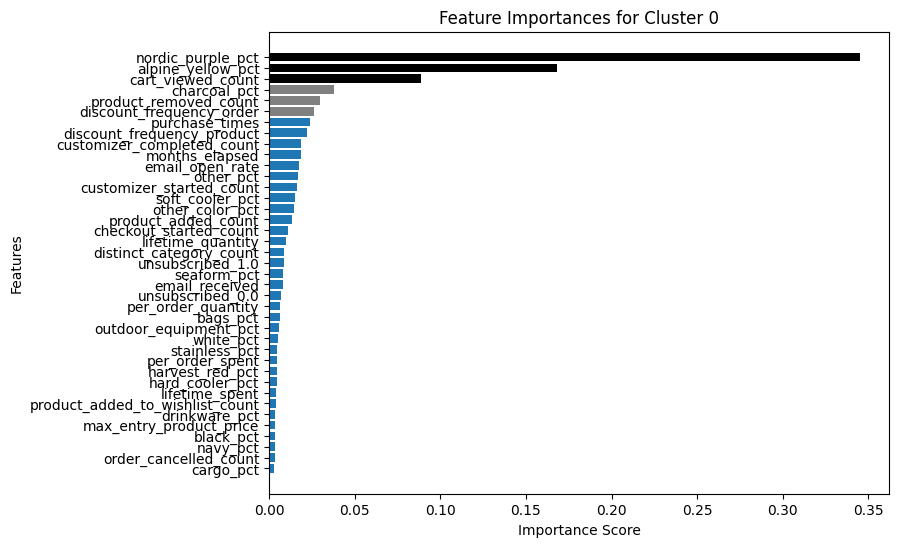

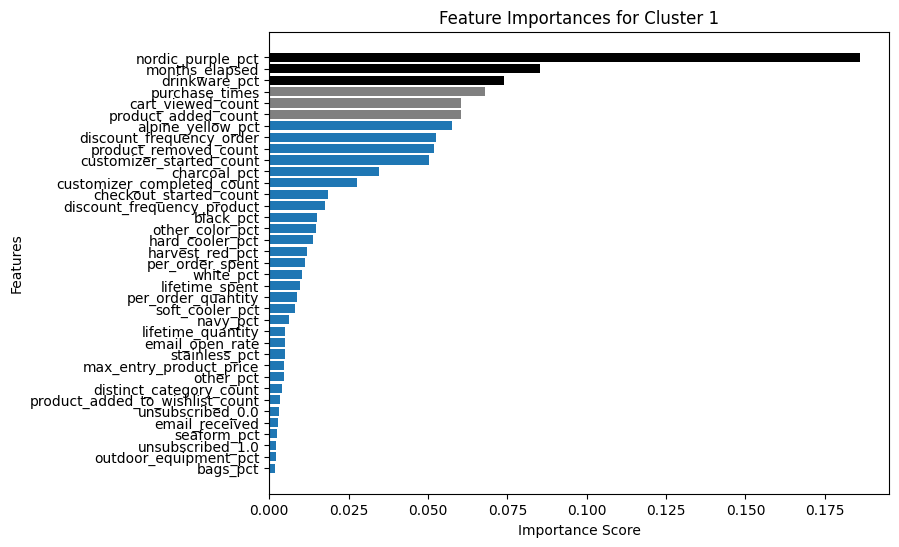

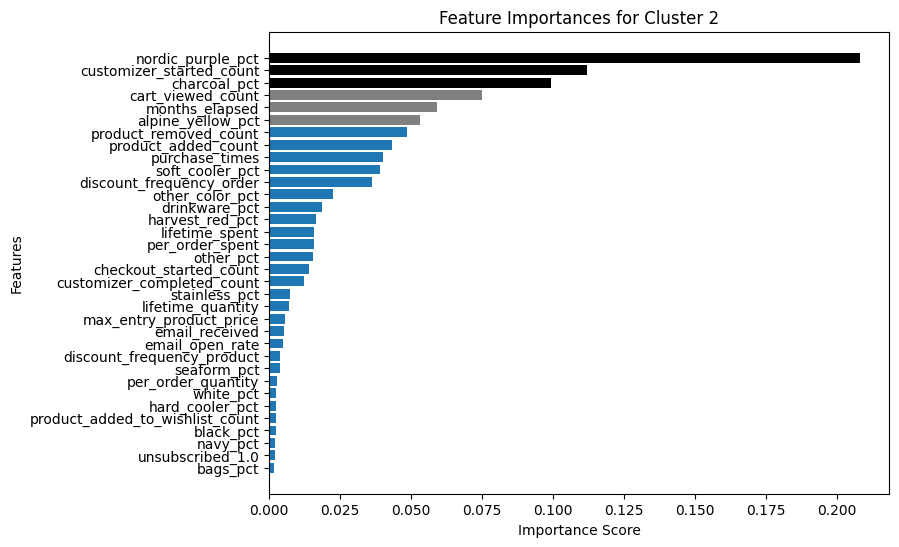

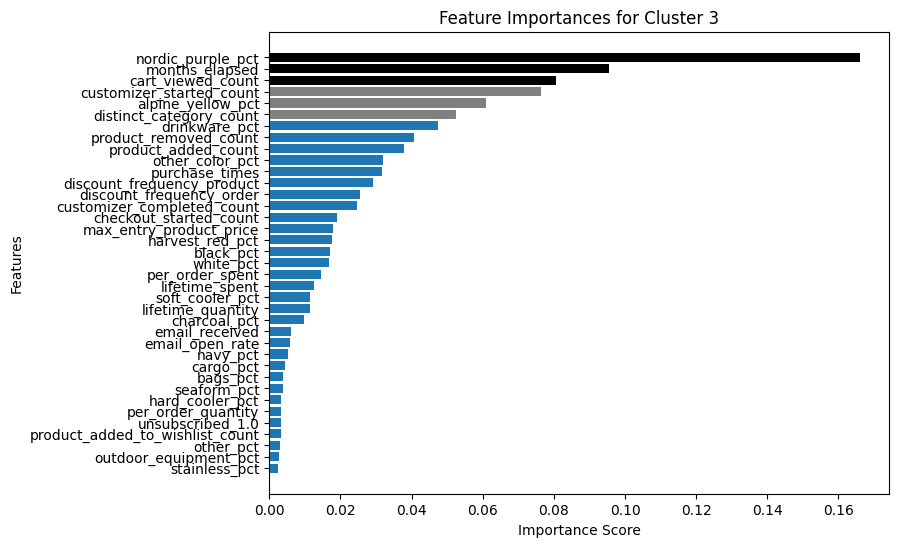

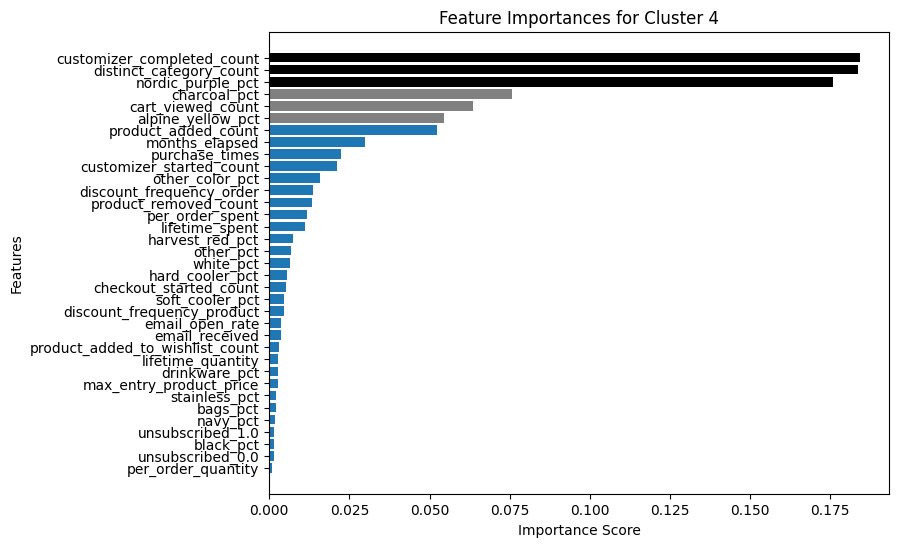

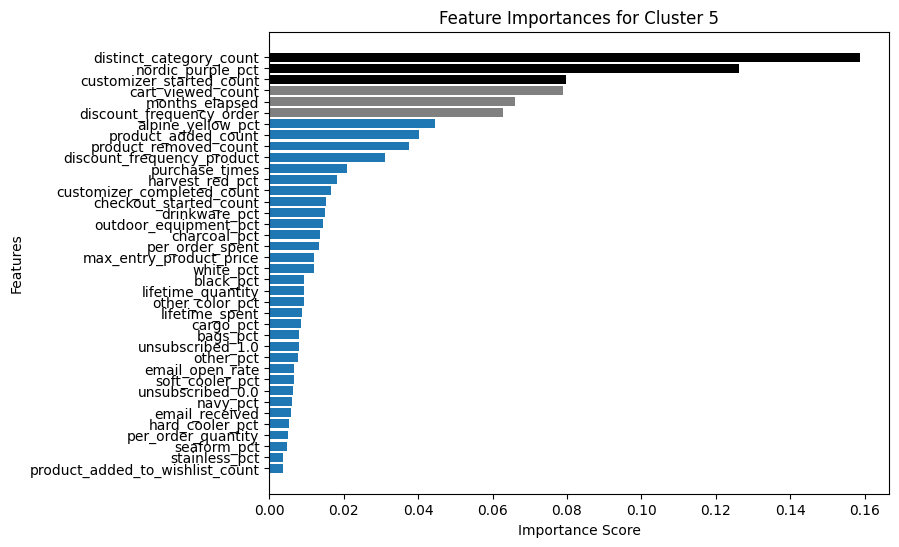

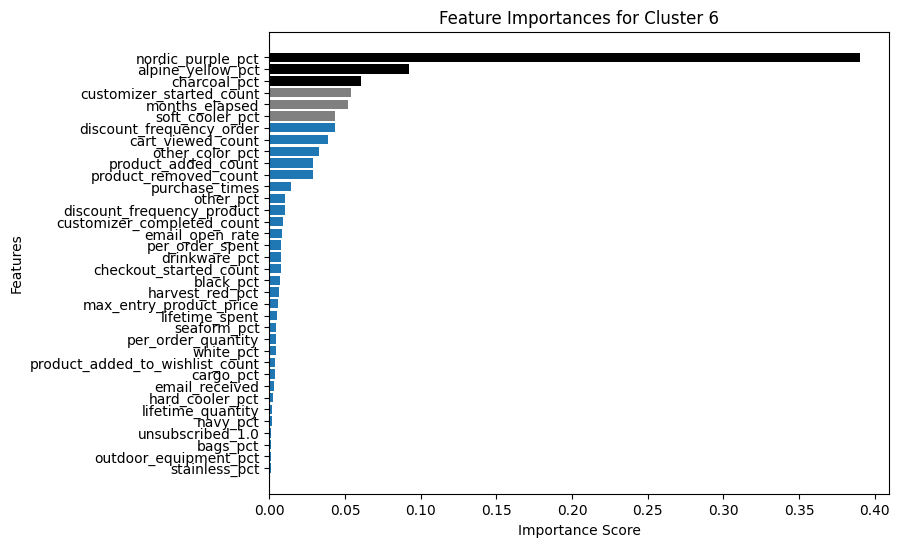

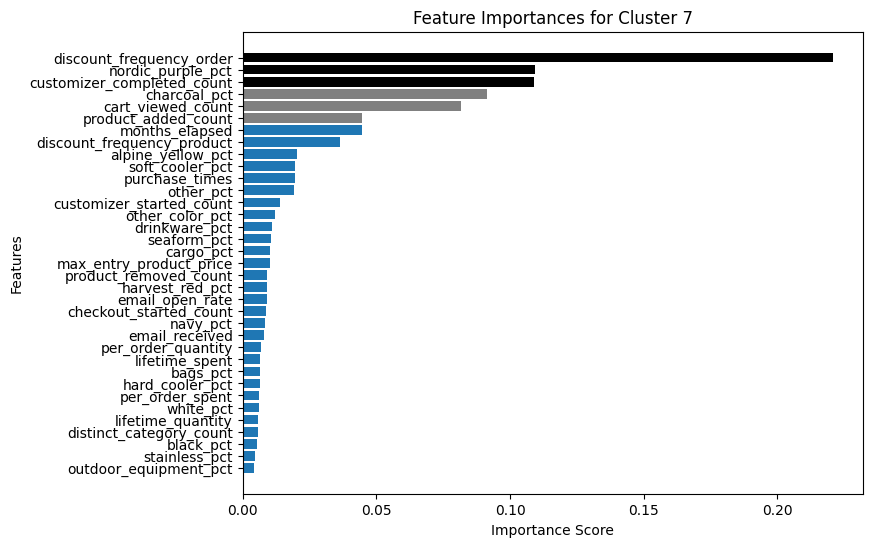

In [ ]:
for i in range(len(feature_importance_wide)):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    values = feature_importance_wide.iloc[i, :]
    values_sorted = values.sort_values(ascending=True) # Sort by value in descending order
    nonzero_values = values_sorted[values_sorted != 0]
    sorted_idx = np.argsort(nonzero_values)[::-1]
    top3_idx = sorted_idx[:3]
    top6_idx = sorted_idx[3:6]
    
    ax.barh(nonzero_values.index, nonzero_values.values, label=f'Row {i}')
    
    # Mark the top 3 features with black bars
    for idx in top3_idx:
        ax.barh(nonzero_values.index[idx], nonzero_values.values[idx], color='black')
    
    # Mark the top 4-6 features with grey bars
    for idx in top6_idx:
        ax.barh(nonzero_values.index[idx], nonzero_values.values[idx], color='grey')
    
    # Set the plot title and labels
    ax.set_title(f'Feature Importances for Cluster {i}')
    ax.set_xlabel('Importance Score')
    ax.set_ylabel('Features')
    
    # Show the plot
    plt.show()


#### Top 3 PDP

In [ ]:
import warnings
warnings.simplefilter("ignore")

cluster 0's Cross Validation Accuracy: 0.7630203610584454
cluster 0's Confusion Matrix:
[[7365 1628]
 [1990 4181]]
cluster 0's Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80      8993
         1.0       0.72      0.68      0.70      6171

    accuracy                           0.76     15164
   macro avg       0.75      0.75      0.75     15164
weighted avg       0.76      0.76      0.76     15164

cluster 0's Accuracy: 0.7614085993141652 

Cluster 0 average churn probability: 38.31%
cluster 0's Computation Time: 20.380355834960938 



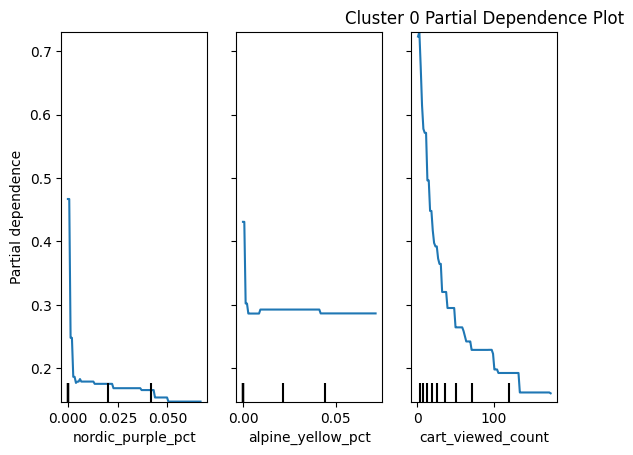

cluster 1's Cross Validation Accuracy: 0.7931998626208167
cluster 1's Confusion Matrix:
[[5386 2552]
 [1376 9642]]
cluster 1's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.73      7938
         1.0       0.79      0.88      0.83     11018

    accuracy                           0.79     18956
   macro avg       0.79      0.78      0.78     18956
weighted avg       0.79      0.79      0.79     18956

cluster 1's Accuracy: 0.7927832876134205 

Cluster 1 average churn probability: 64.33%
cluster 1's Computation Time: 73.53666257858276 



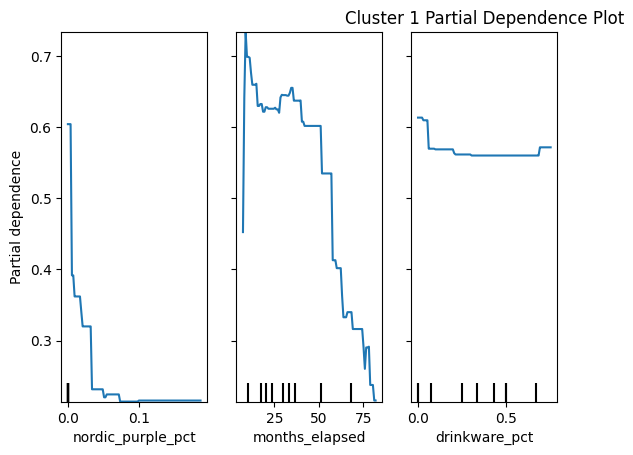

cluster 2's Cross Validation Accuracy: 0.8038549289649417
cluster 2's Confusion Matrix:
[[22700 10692]
 [ 5683 44571]]
cluster 2's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.73     33392
         1.0       0.81      0.89      0.84     50254

    accuracy                           0.80     83646
   macro avg       0.80      0.78      0.79     83646
weighted avg       0.80      0.80      0.80     83646

cluster 2's Accuracy: 0.8042345121105612 

Cluster 2 average churn probability: 66.07%
cluster 2's Computation Time: 181.91700863838196 



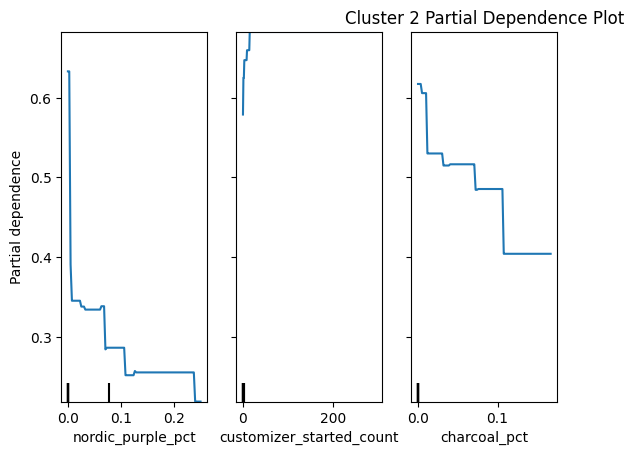

cluster 3's Cross Validation Accuracy: 0.7733505901499038
cluster 3's Confusion Matrix:
[[5070 2042]
 [1243 6998]]
cluster 3's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.71      0.76      7112
         1.0       0.77      0.85      0.81      8241

    accuracy                           0.79     15353
   macro avg       0.79      0.78      0.78     15353
weighted avg       0.79      0.79      0.78     15353

cluster 3's Accuracy: 0.7860353025467335 

Cluster 3 average churn probability: 58.88%
cluster 3's Computation Time: 61.51876211166382 



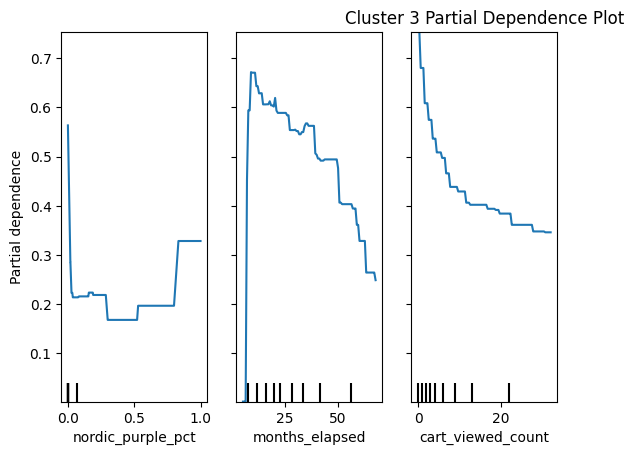

cluster 4's Cross Validation Accuracy: 0.8019055346519227
cluster 4's Confusion Matrix:
[[34383 13403]
 [ 8479 54886]]
cluster 4's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76     47786
         1.0       0.80      0.87      0.83     63365

    accuracy                           0.80    111151
   macro avg       0.80      0.79      0.80    111151
weighted avg       0.80      0.80      0.80    111151

cluster 4's Accuracy: 0.8031326753695424 

Cluster 4 average churn probability: 61.44%
cluster 4's Computation Time: 255.15456128120422 



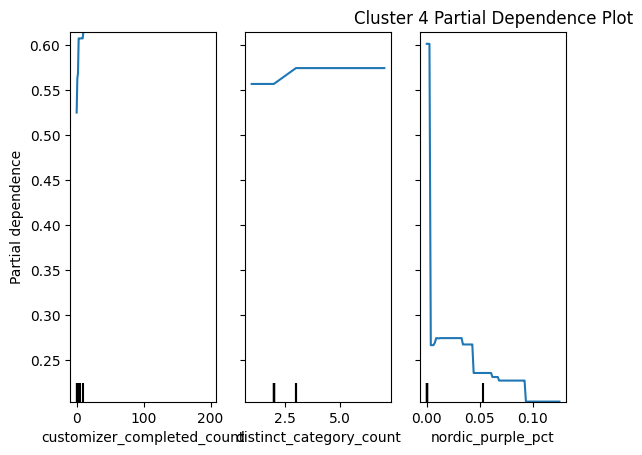

cluster 5's Cross Validation Accuracy: 0.7644746420496045
cluster 5's Confusion Matrix:
[[1758  853]
 [ 565 2805]]
cluster 5's Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.67      0.71      2611
         1.0       0.77      0.83      0.80      3370

    accuracy                           0.76      5981
   macro avg       0.76      0.75      0.76      5981
weighted avg       0.76      0.76      0.76      5981

cluster 5's Accuracy: 0.7629159003511119 

Cluster 5 average churn probability: 61.16%
cluster 5's Computation Time: 56.817298412323 



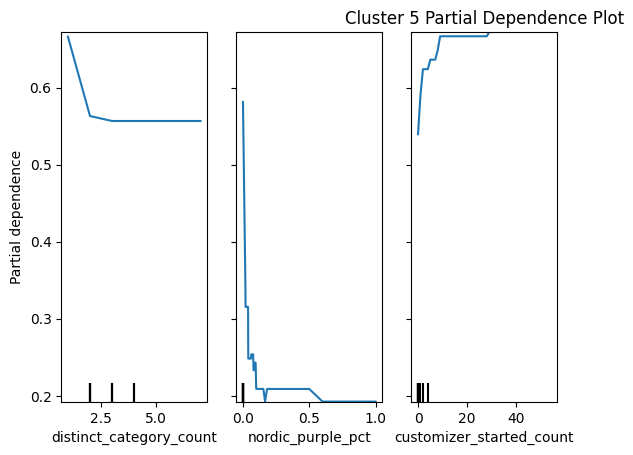

cluster 6's Cross Validation Accuracy: 0.807638789373725
cluster 6's Confusion Matrix:
[[18327  6218]
 [ 3357 22231]]
cluster 6's Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.79     24545
         1.0       0.78      0.87      0.82     25588

    accuracy                           0.81     50133
   macro avg       0.81      0.81      0.81     50133
weighted avg       0.81      0.81      0.81     50133

cluster 6's Accuracy: 0.809008038617278 

Cluster 6 average churn probability: 56.75%
cluster 6's Computation Time: 146.52724409103394 



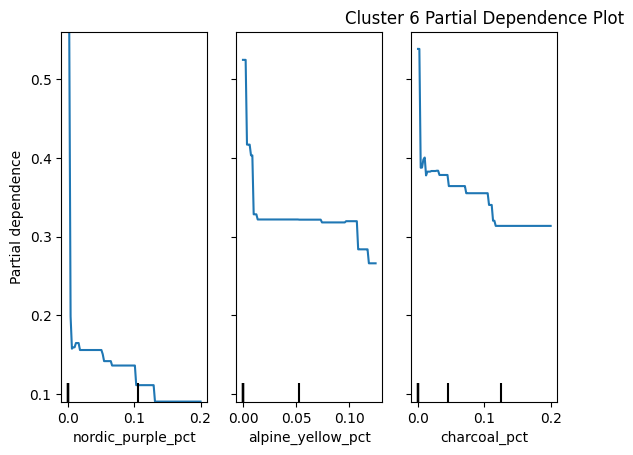

cluster 7's Cross Validation Accuracy: 0.8244398232468427
cluster 7's Confusion Matrix:
[[1070  292]
 [ 180 1316]]
cluster 7's Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82      1362
         1.0       0.82      0.88      0.85      1496

    accuracy                           0.83      2858
   macro avg       0.84      0.83      0.83      2858
weighted avg       0.84      0.83      0.83      2858

cluster 7's Accuracy: 0.834849545136459 

Cluster 7 average churn probability: 56.26%
cluster 7's Computation Time: 9.159164667129517 



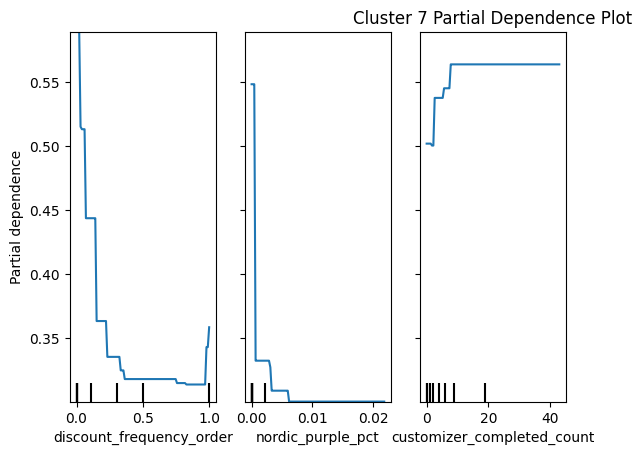

In [ ]:
from sklearn.inspection import plot_partial_dependence
# create an empty dataframe to store the computation time
Xgb_time=pd.DataFrame(columns=["Cluster","Time"])

# create an empty dataframe to store the feature importance scores
feature_importance_df = pd.DataFrame(columns=['Cluster', 'Feature', 'Importance'])

for i in range(0, 8):
    start_time = time.time() # Start the timer
    df_ada = globals()['df_cluster_short{}'.format(i)]
    df_ada=df_ada.drop(['avg_time_btw_orders', 'recency'],axis=1)

    y_data=df_ada.churn
    x_data=df_ada.drop(['churn'],axis=1)
    
    
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state = 42
                                                       )
    
    Xgb_clf = xgb.XGBClassifier(max_depth=2,n_estimators=150,learning_rate=0.5)
    
    
    # Cross-validation
    cv_results = cross_validate(Xgb_clf, X_train, y_train, cv=5, scoring='accuracy')
    cv_accuracy = cv_results['test_score']
    print("cluster {}'s Cross Validation Accuracy:".format(i), cv_accuracy.mean())
    
    
    Xgb_clf.fit(X_train, y_train)
    
    ypred=Xgb_clf.predict(X_test) #These are the predicted output values
    
    # Get the feature importance scores for testing sets!!!!
    feature_importances = Xgb_clf.feature_importances_

    # add the feature importance scores to the dataframe
    for j in range(len(feature_importances)):
        feature_importance_df = feature_importance_df.append({'Cluster': i, 'Feature': x_data.columns[j], 'Importance': feature_importances[j]}, ignore_index=True)
    
    sorted_indices = np.argsort(feature_importances)[::-1]

    # Get the top 3 features and run ALE plot
    top_3_features = x_data.columns[sorted_indices][:3]

    
    
    
    result = confusion_matrix(y_test, ypred)
    end_time = time.time() # End the timer
    print("cluster {}'s Confusion Matrix:".format(i))
    print(result)

    result1 = classification_report(y_test, ypred)
    print("cluster {}'s Classification Report:".format(i))
    print (result1)

    result2 = accuracy_score(y_test,ypred)
    print("cluster {}'s Accuracy:".format(i),result2,"\n")
    
    positive_pred_percent = np.sum(ypred == 1) / len(y_test) * 100
    print("Cluster {} average churn probability: {:.2f}%".format(i, positive_pred_percent))

    

    time_lapse=end_time - start_time
    Xgb_time.loc[i]=[i,time_lapse]

    print("cluster {}'s Computation Time:".format(i),time_lapse, "\n") # Print the computation time
    

    # Create the partial dependence plot
    plot_partial_dependence(Xgb_clf, X_test, top_3_features, feature_names=x_data.columns.tolist())

    # Set the title of the plot
    plt.title("Cluster {} Partial Dependence Plot".format(i))

    # Show the plot
    plt.show()

#### Top 3 ALE

- We add a feature that is totally random noice so that we can have comparable indicator for feature importance.

cluster 0's Cross Validation Accuracy: 0.7629049542494435


PyALE._ALE_generic:INFO: Continuous feature detected.


cluster 0's Confusion Matrix:
[[7350 1643]
 [1985 4186]]
cluster 0's Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80      8993
         1.0       0.72      0.68      0.70      6171

    accuracy                           0.76     15164
   macro avg       0.75      0.75      0.75     15164
weighted avg       0.76      0.76      0.76     15164

cluster 0's Accuracy: 0.7607491427064099 

cluster 0's Computation Time: 146.57977199554443 

ALE plot for Cluster 0, feature 1


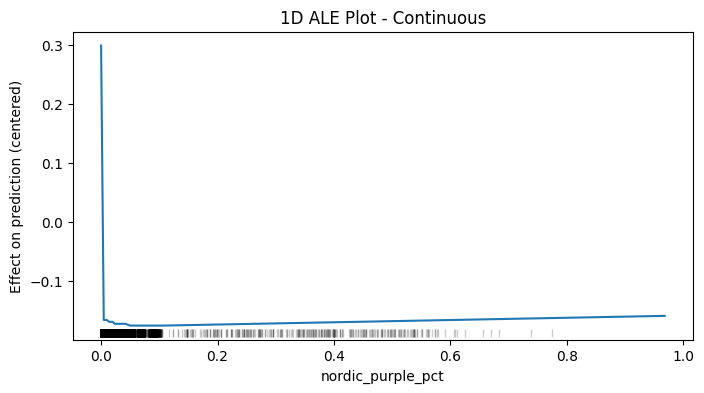

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 2


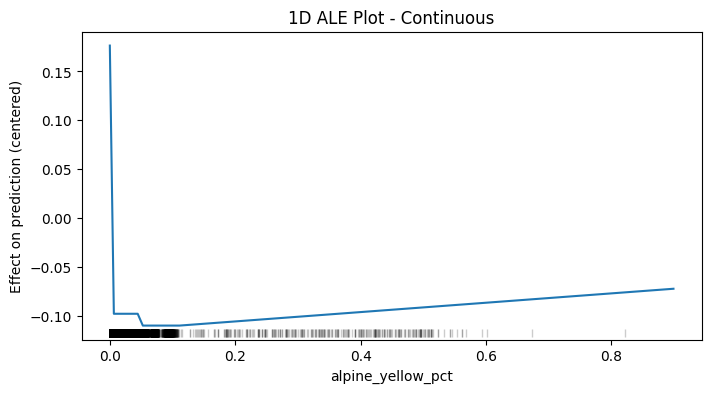

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 3


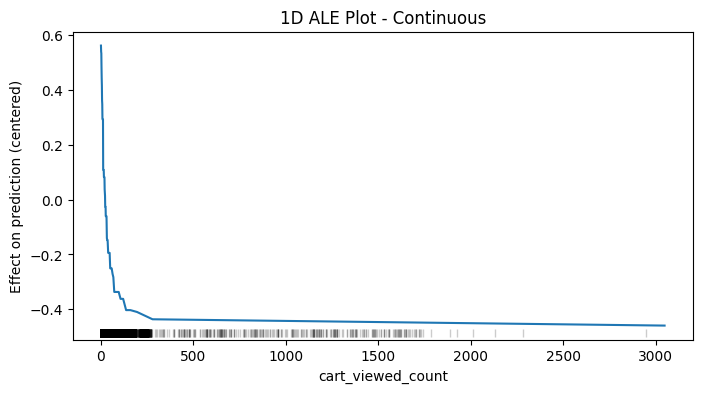

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 4


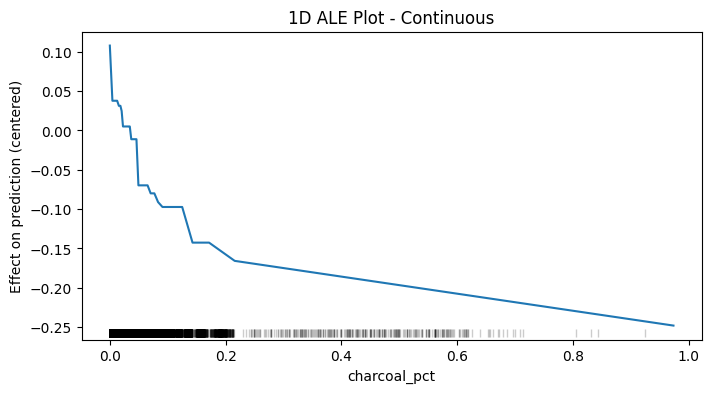

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 5


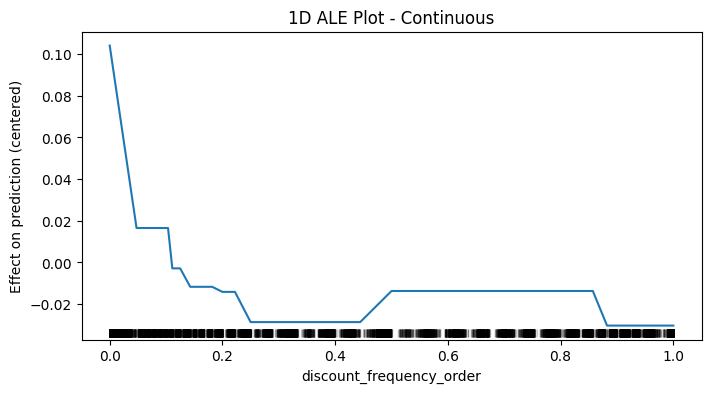

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 6


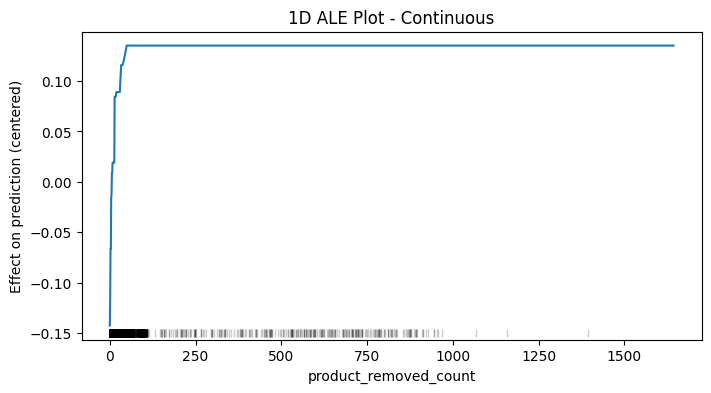

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 7


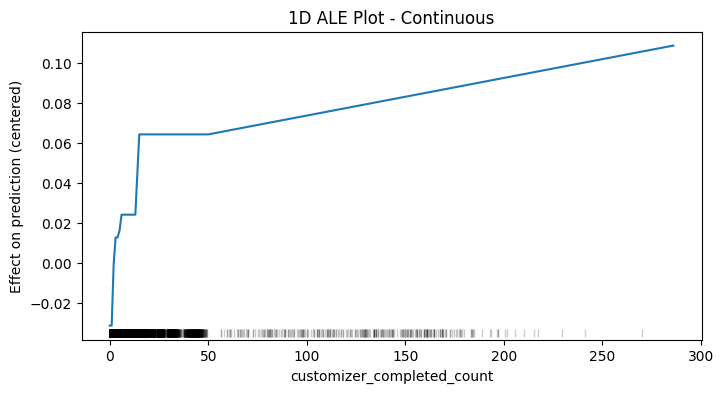

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 8


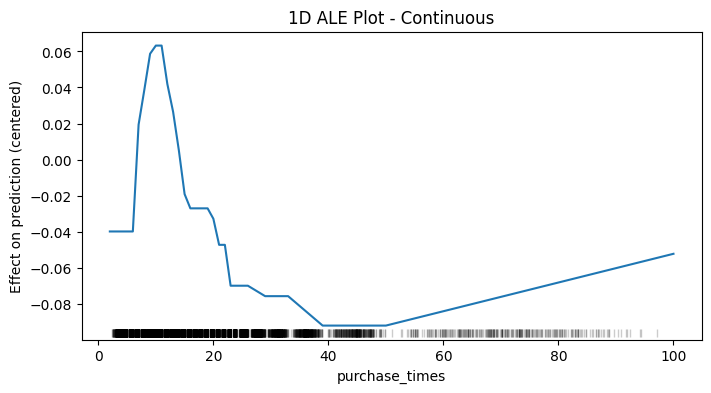

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 9


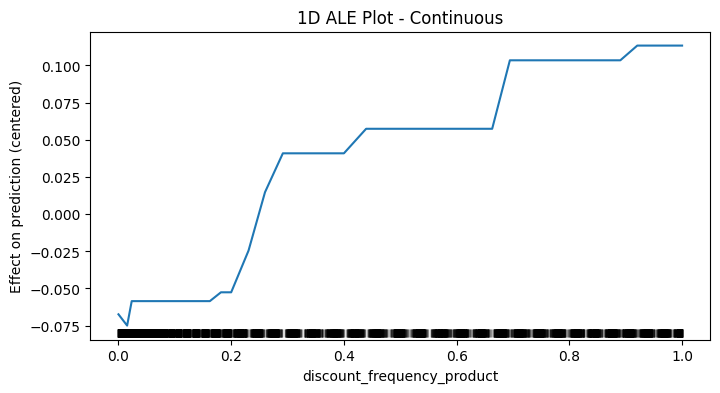

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0, feature 10


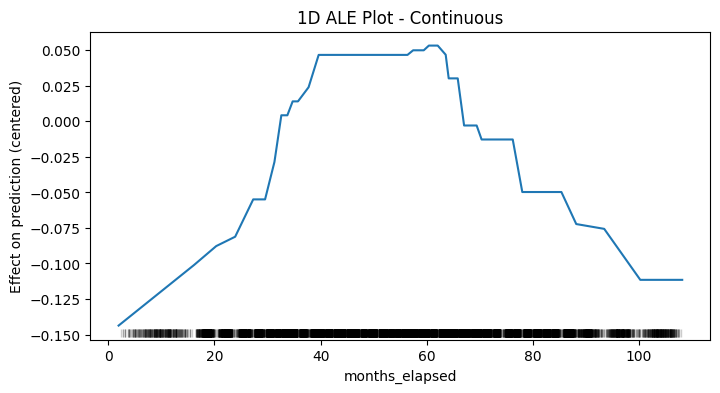

cluster 1's Cross Validation Accuracy: 0.7925800203737955


PyALE._ALE_generic:INFO: Continuous feature detected.


cluster 1's Confusion Matrix:
[[5385 2553]
 [1380 9638]]
cluster 1's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.73      7938
         1.0       0.79      0.87      0.83     11018

    accuracy                           0.79     18956
   macro avg       0.79      0.78      0.78     18956
weighted avg       0.79      0.79      0.79     18956

cluster 1's Accuracy: 0.7925195188858409 

cluster 1's Computation Time: 138.21515369415283 

ALE plot for Cluster 1, feature 1


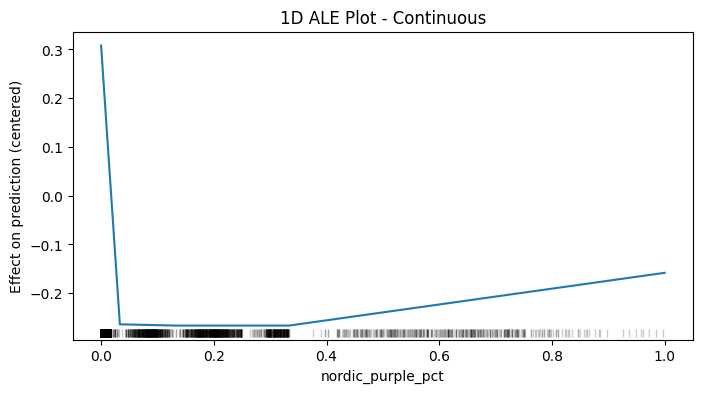

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1, feature 2


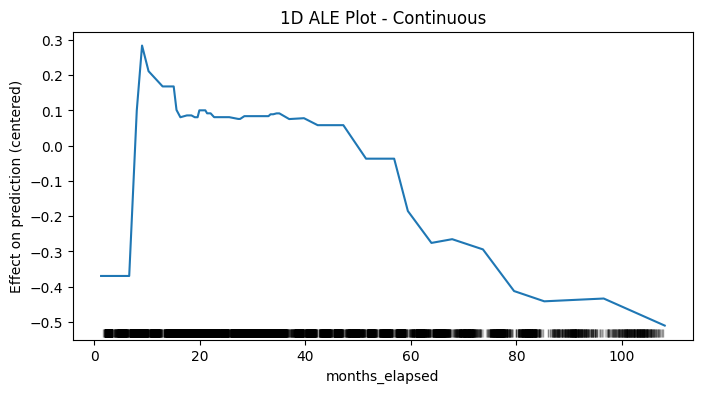

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1, feature 3


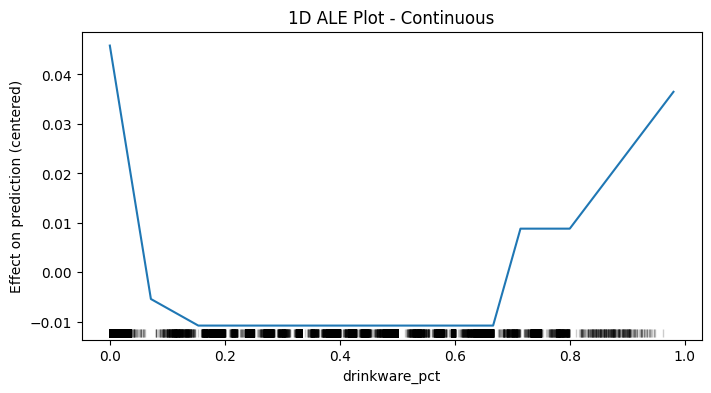

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1, feature 4


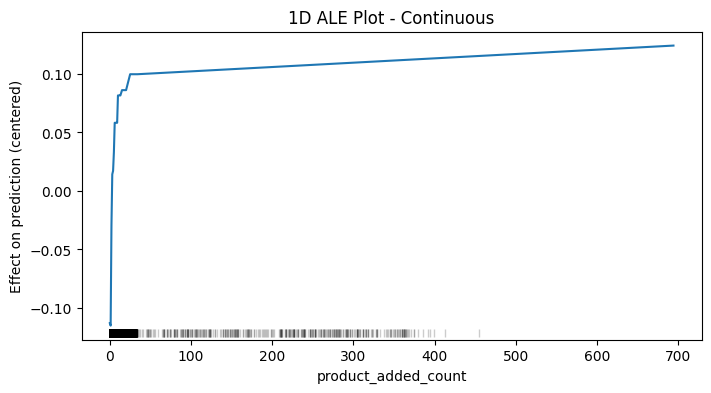

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1, feature 5


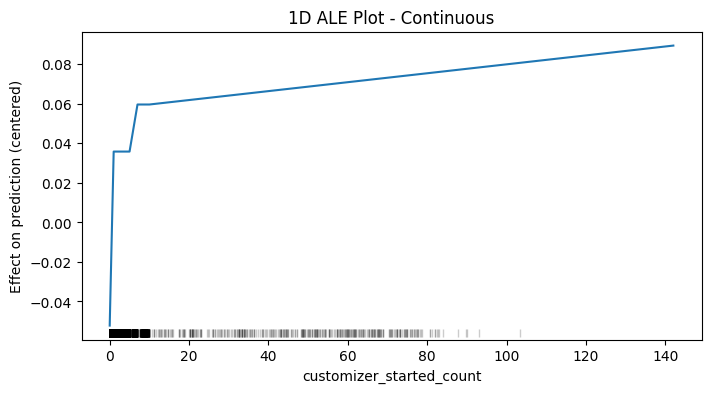

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1, feature 6


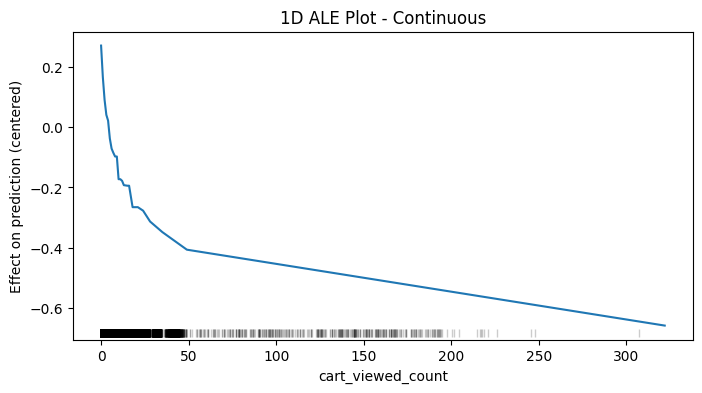

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1, feature 7


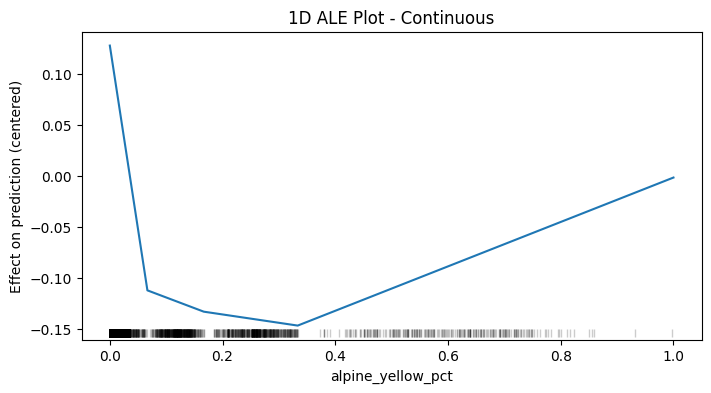

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 1, feature 8


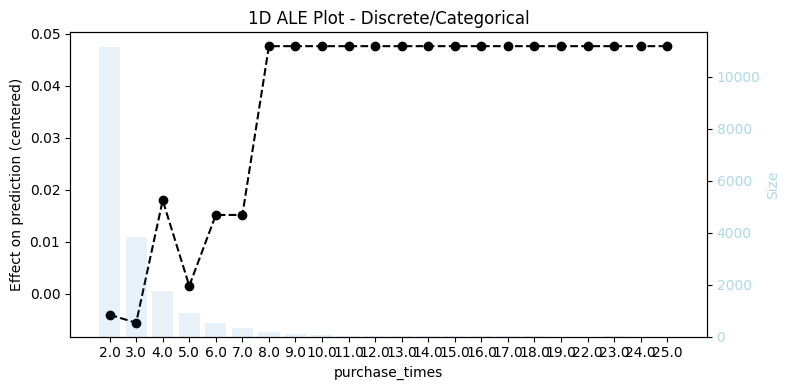

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1, feature 9


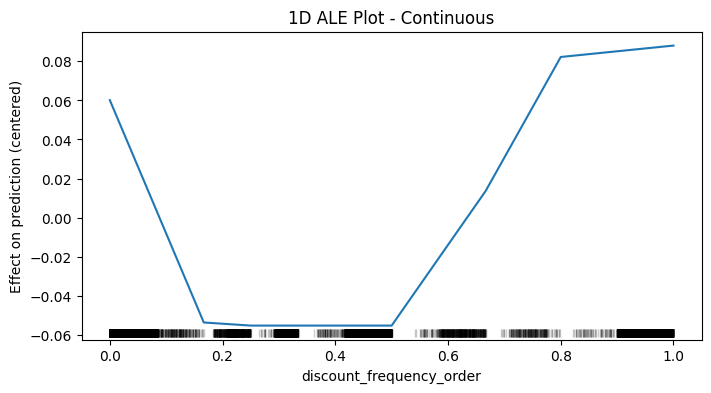

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1, feature 10


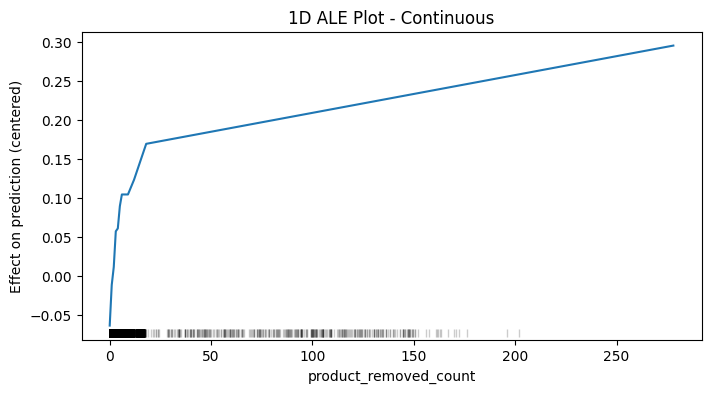

cluster 2's Cross Validation Accuracy: 0.8039147054010707
cluster 2's Confusion Matrix:
[[22700 10692]
 [ 5683 44571]]


PyALE._ALE_generic:INFO: Continuous feature detected.


cluster 2's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.73     33392
         1.0       0.81      0.89      0.84     50254

    accuracy                           0.80     83646
   macro avg       0.80      0.78      0.79     83646
weighted avg       0.80      0.80      0.80     83646

cluster 2's Accuracy: 0.8042345121105612 

cluster 2's Computation Time: 293.0843017101288 

ALE plot for Cluster 2, feature 1


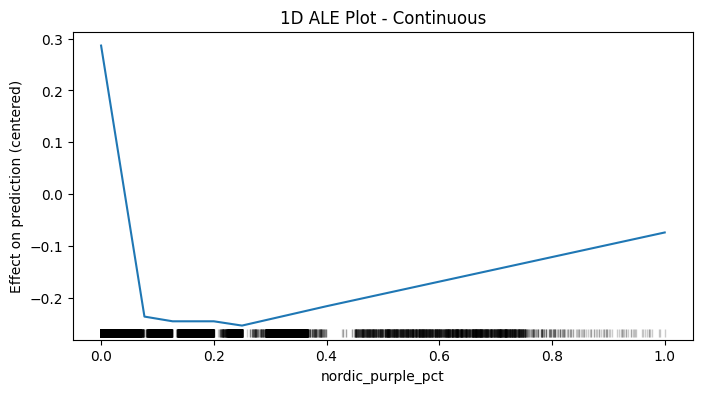

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 2, feature 2


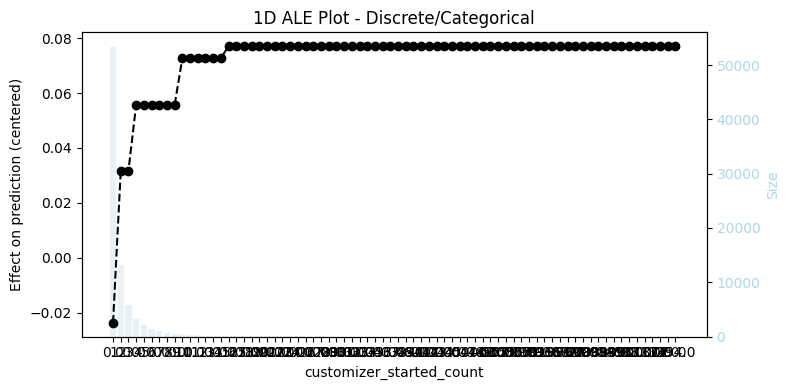

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 2, feature 3


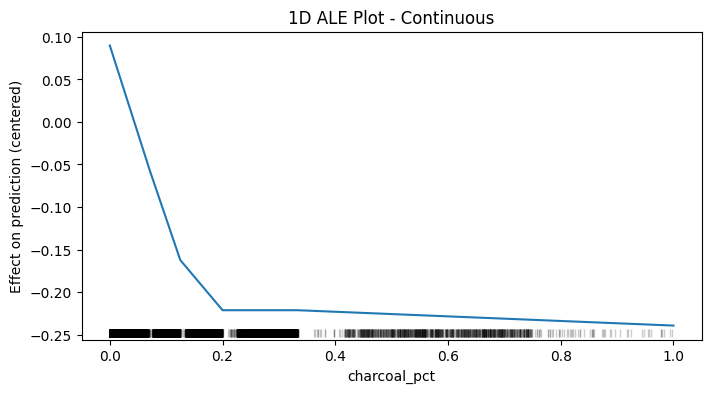

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 2, feature 4


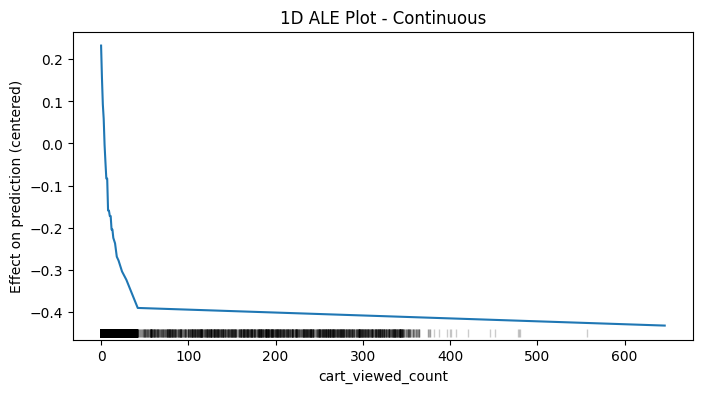

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 2, feature 5


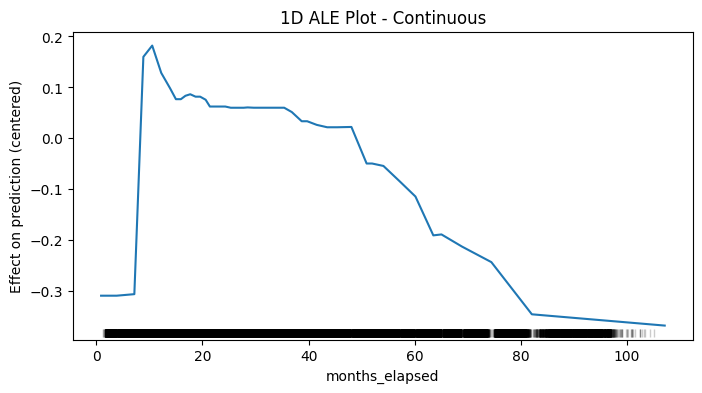

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 2, feature 6


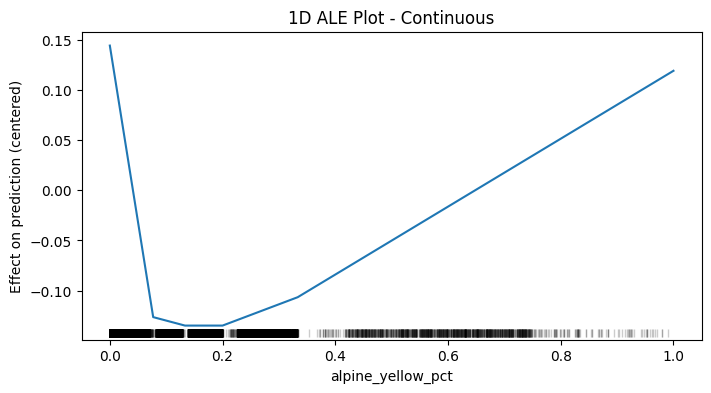

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 2, feature 7


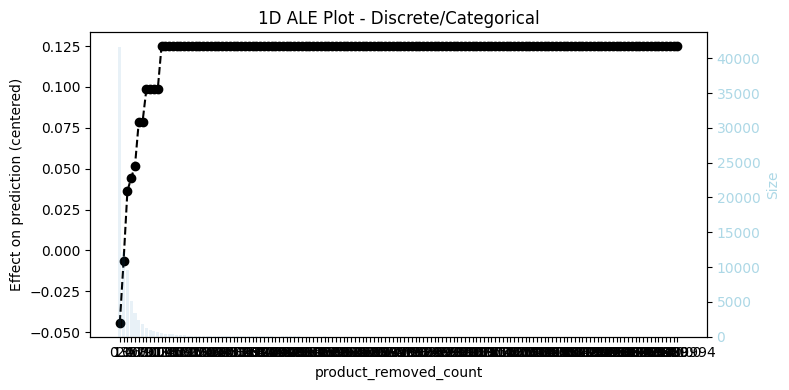

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 2, feature 8


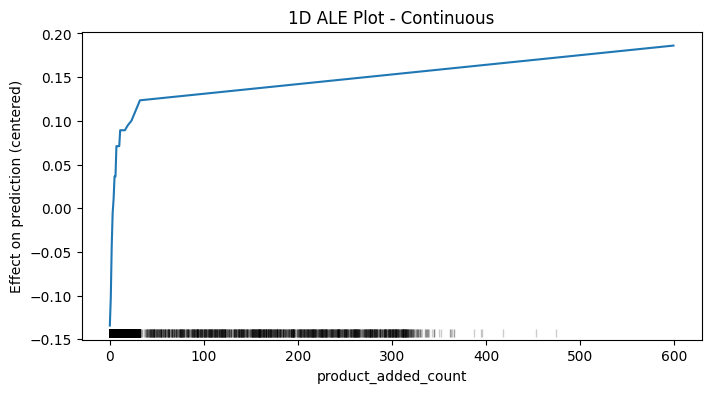

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 2, feature 9


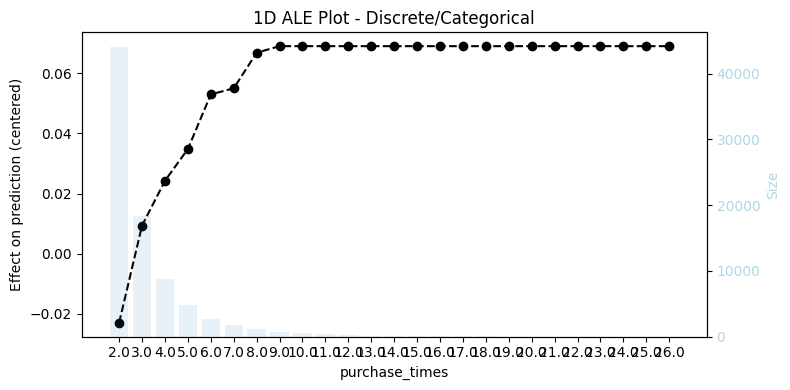

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 2, feature 10


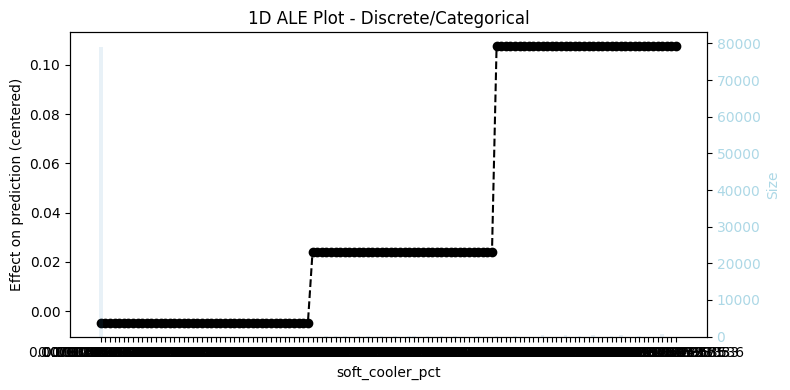

cluster 3's Cross Validation Accuracy: 0.7731389207805291


PyALE._ALE_generic:INFO: Continuous feature detected.


cluster 3's Confusion Matrix:
[[5049 2063]
 [1262 6979]]
cluster 3's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75      7112
         1.0       0.77      0.85      0.81      8241

    accuracy                           0.78     15353
   macro avg       0.79      0.78      0.78     15353
weighted avg       0.78      0.78      0.78     15353

cluster 3's Accuracy: 0.7834299485442584 

cluster 3's Computation Time: 94.41739416122437 

ALE plot for Cluster 3, feature 1


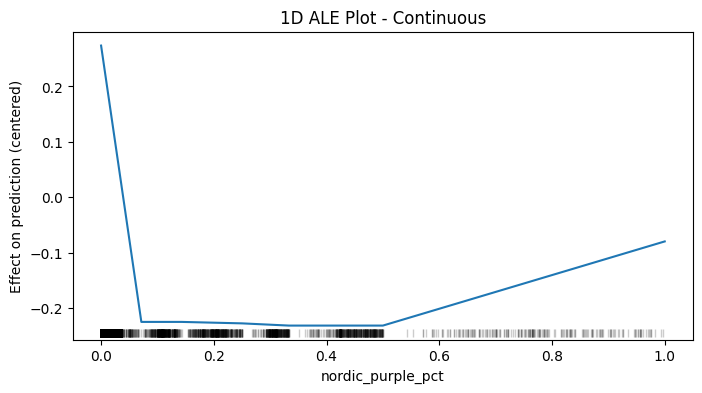

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 3, feature 2


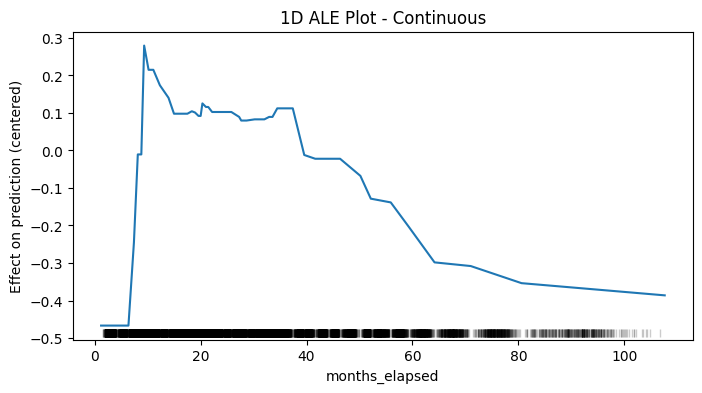

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 3, feature 3


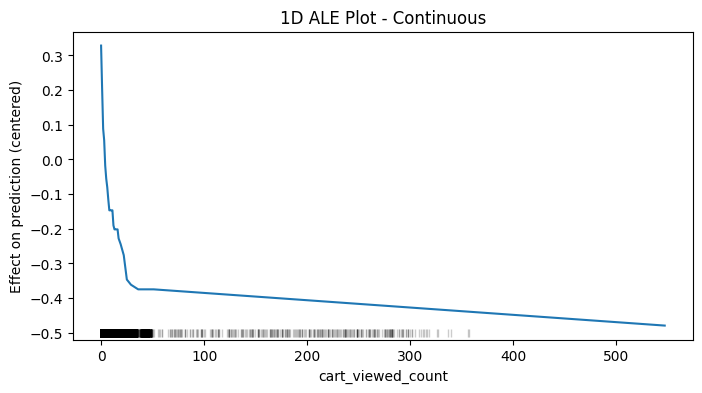

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 3, feature 4


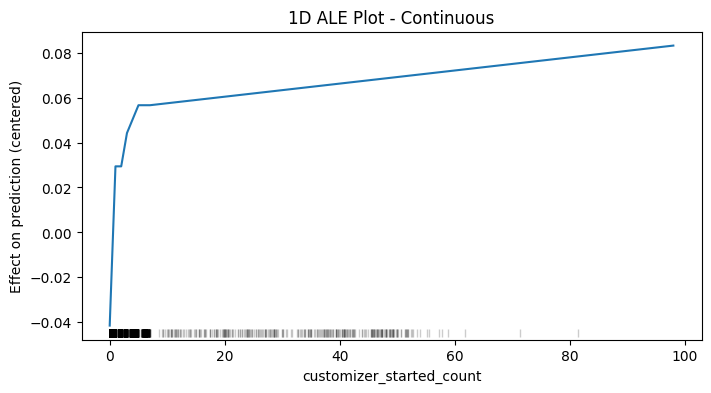

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 3, feature 5


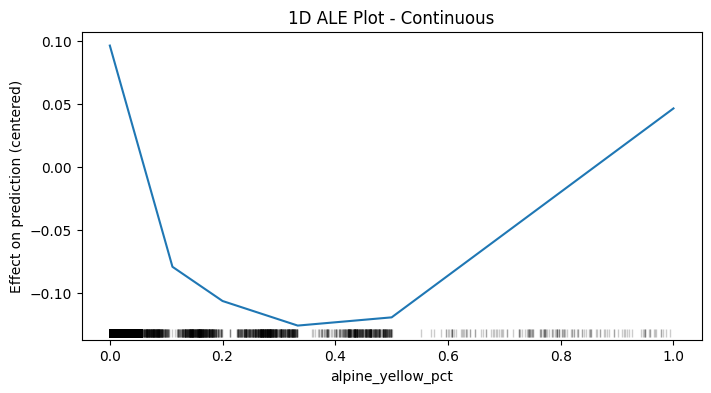

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 3, feature 6


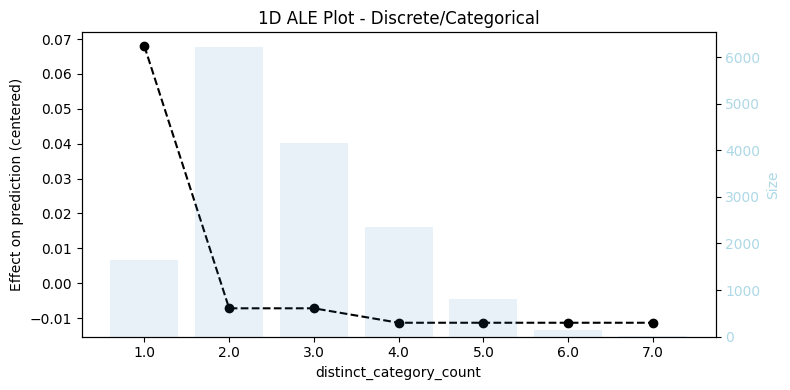

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 3, feature 7


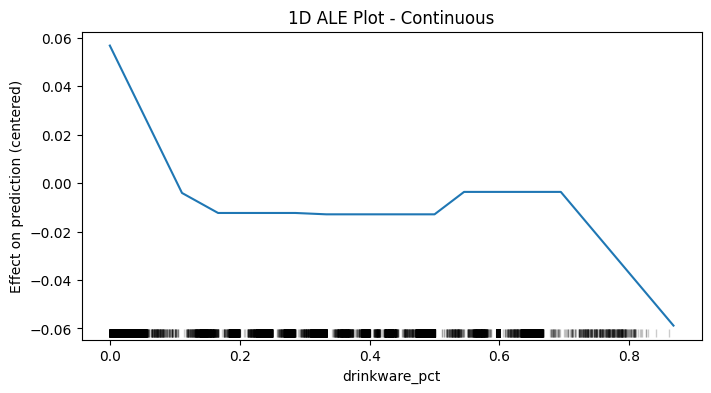

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 3, feature 8


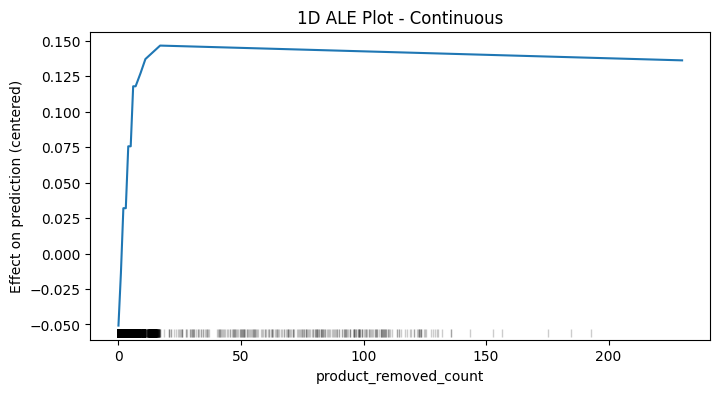

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 3, feature 9


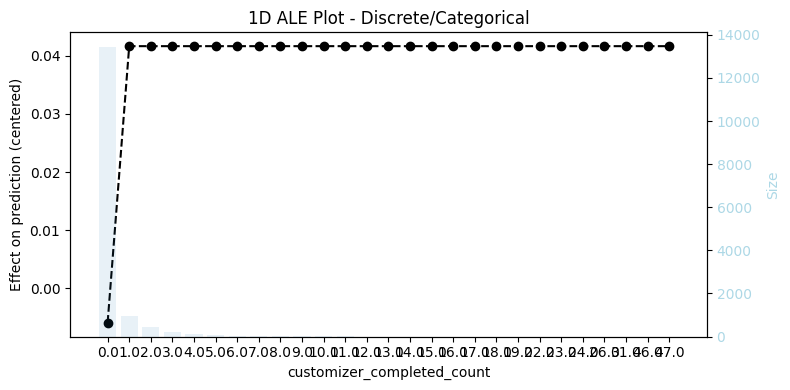

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 3, feature 10


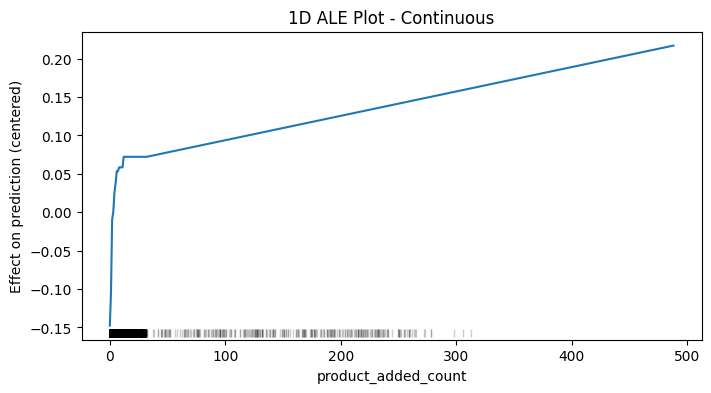

cluster 4's Cross Validation Accuracy: 0.8018920393752695
cluster 4's Confusion Matrix:
[[34383 13403]
 [ 8479 54886]]


PyALE._ALE_generic:INFO: Discrete feature detected.


cluster 4's Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76     47786
         1.0       0.80      0.87      0.83     63365

    accuracy                           0.80    111151
   macro avg       0.80      0.79      0.80    111151
weighted avg       0.80      0.80      0.80    111151

cluster 4's Accuracy: 0.8031326753695424 

cluster 4's Computation Time: 337.3649024963379 

ALE plot for Cluster 4, feature 1


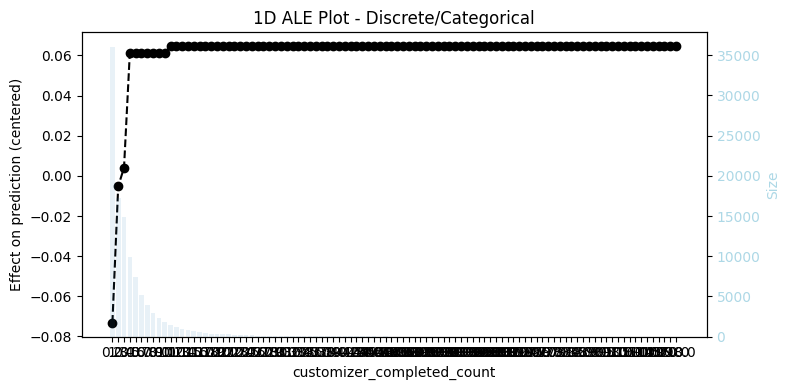

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 4, feature 2


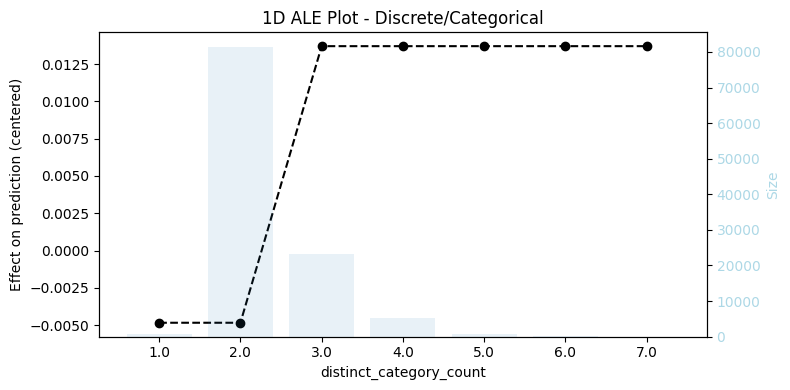

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 4, feature 3


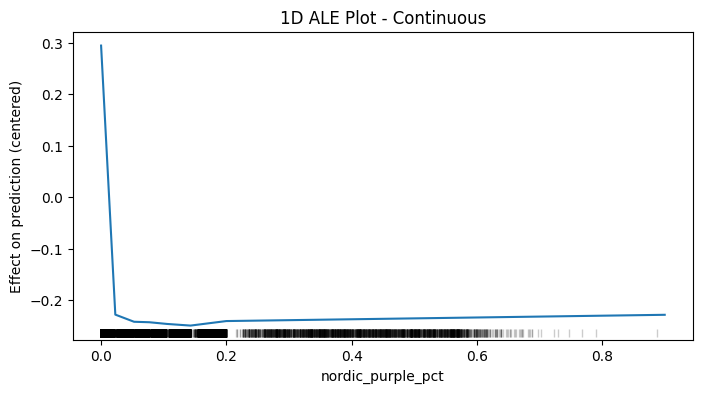

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 4, feature 4


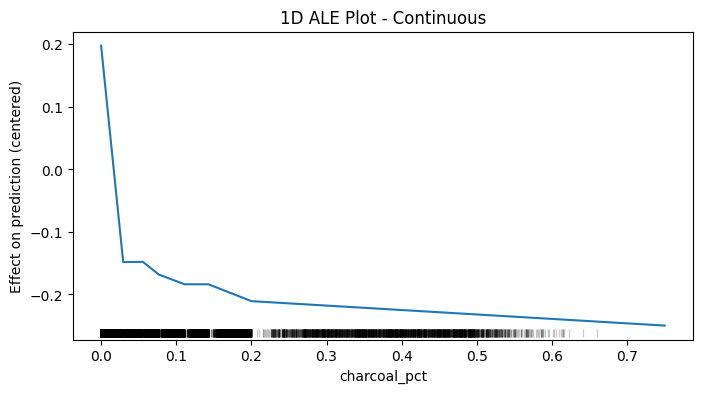

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 4, feature 5


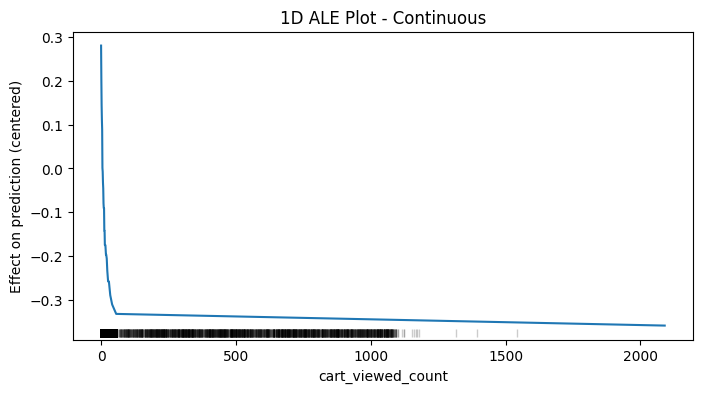

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 4, feature 6


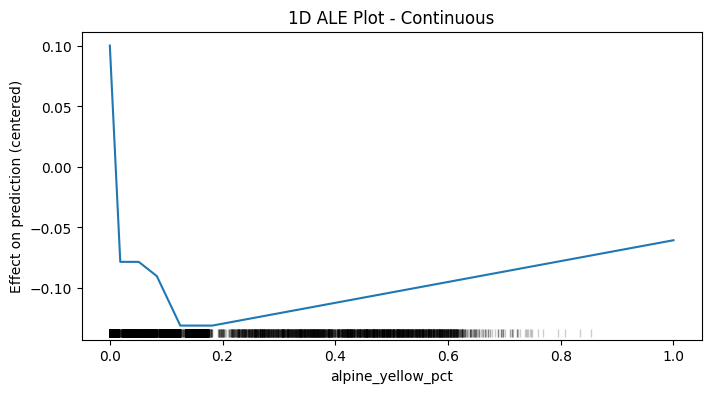

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 4, feature 7


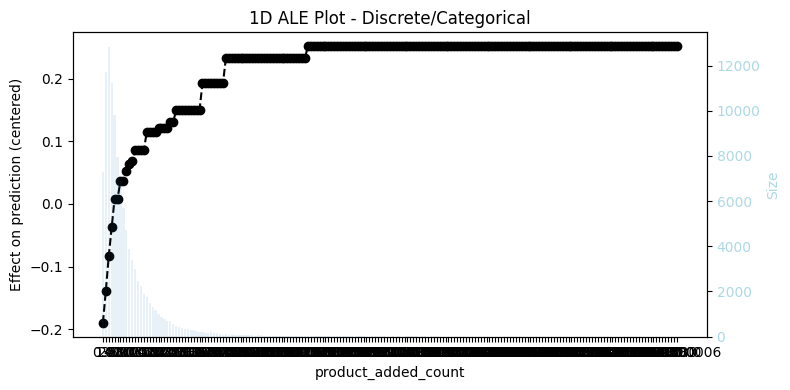

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 4, feature 8


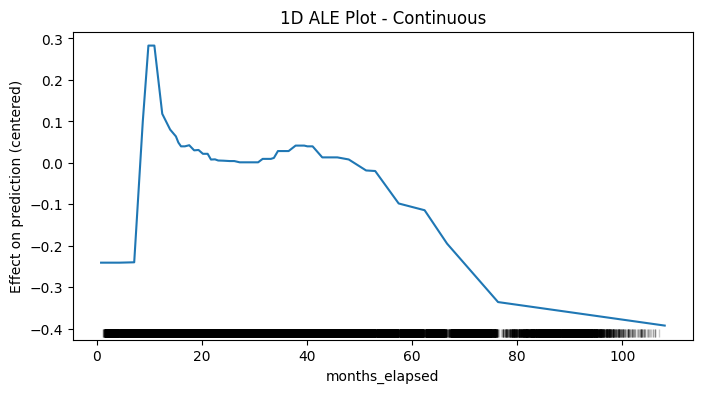

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 4, feature 9


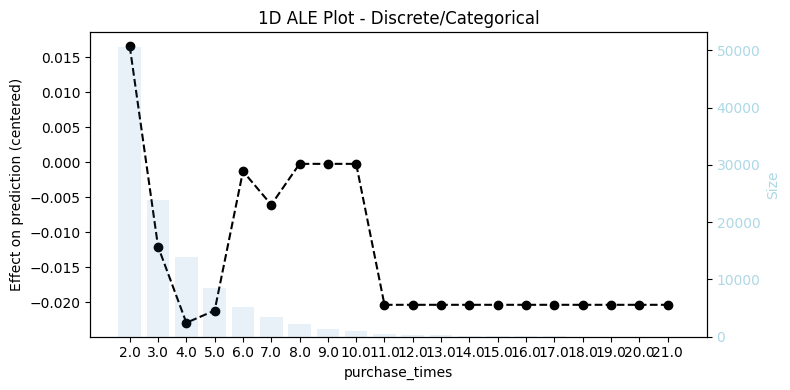

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 4, feature 10


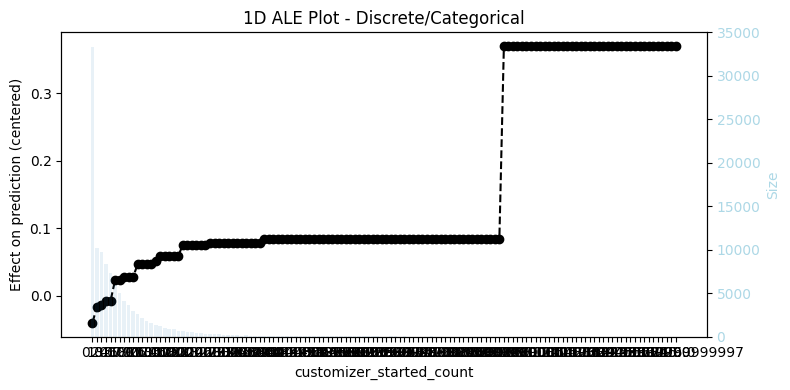

cluster 5's Cross Validation Accuracy: 0.7611306671838906


PyALE._ALE_generic:INFO: Continuous feature detected.


cluster 5's Confusion Matrix:
[[1733  878]
 [ 555 2815]]
cluster 5's Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.66      0.71      2611
         1.0       0.76      0.84      0.80      3370

    accuracy                           0.76      5981
   macro avg       0.76      0.75      0.75      5981
weighted avg       0.76      0.76      0.76      5981

cluster 5's Accuracy: 0.760407958535362 

cluster 5's Computation Time: 90.36520576477051 

ALE plot for Cluster 5, feature 1


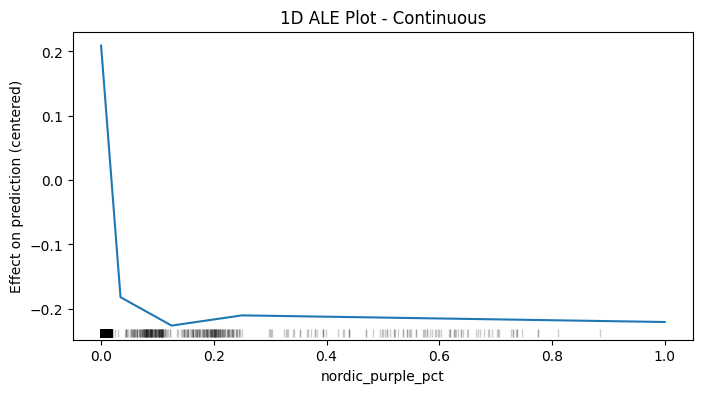

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 5, feature 2


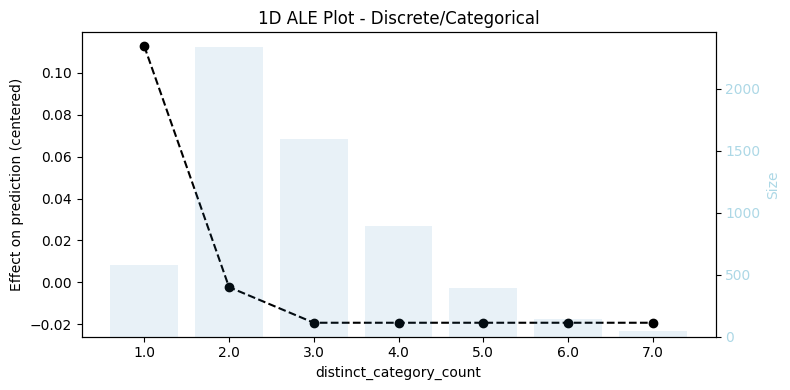

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5, feature 3


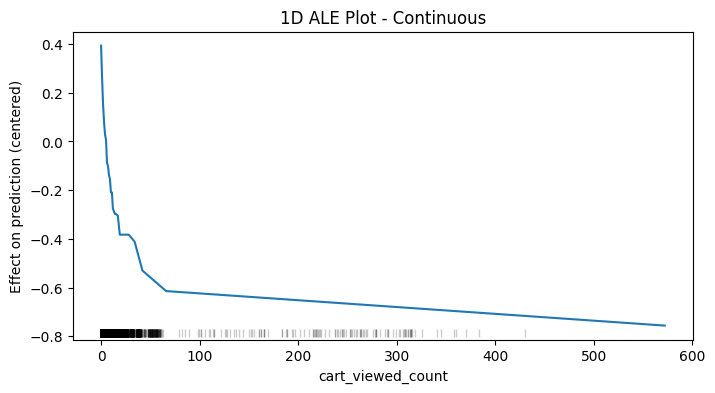

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5, feature 4


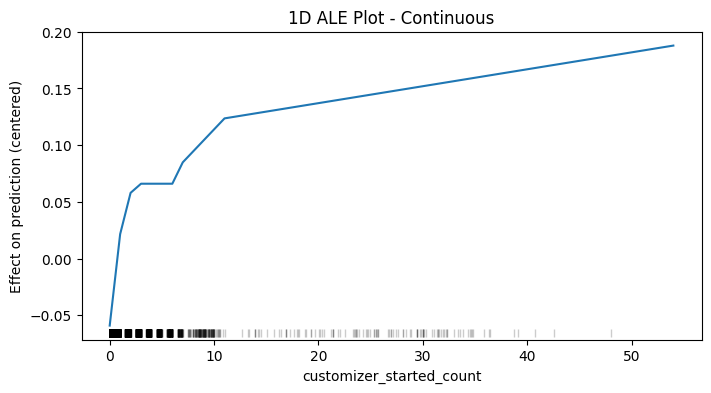

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5, feature 5


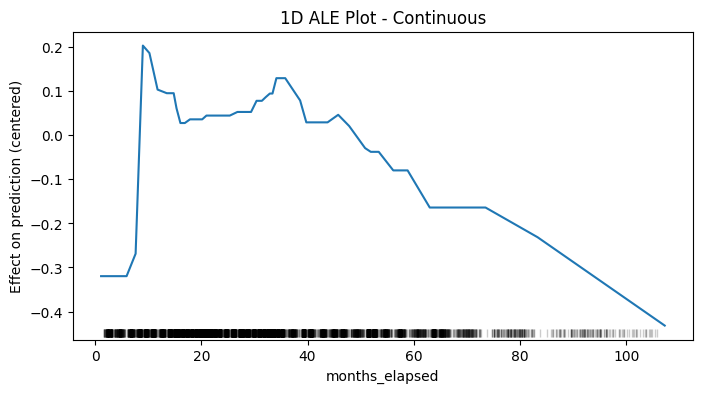

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5, feature 6


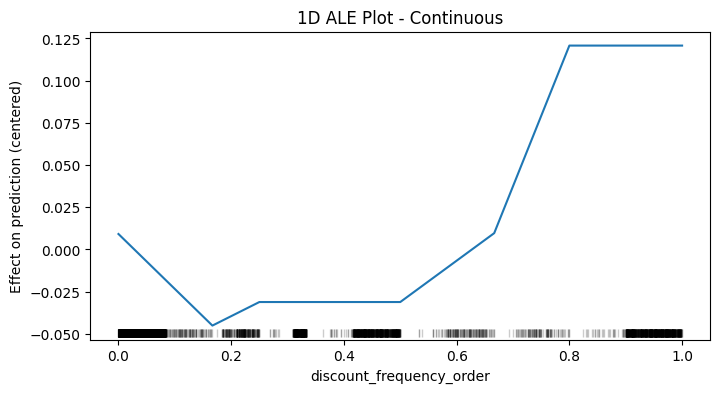

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5, feature 7


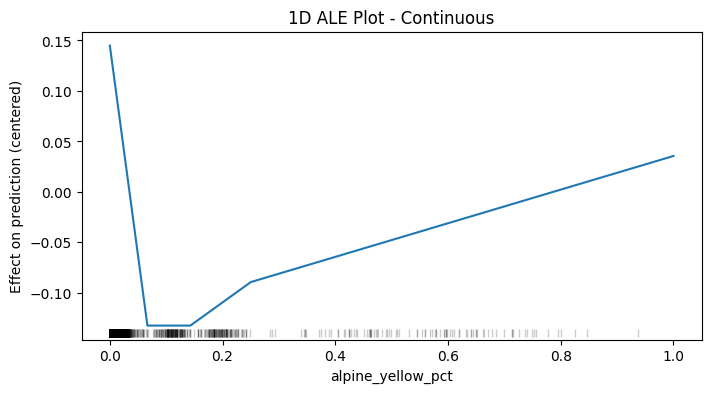

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5, feature 8


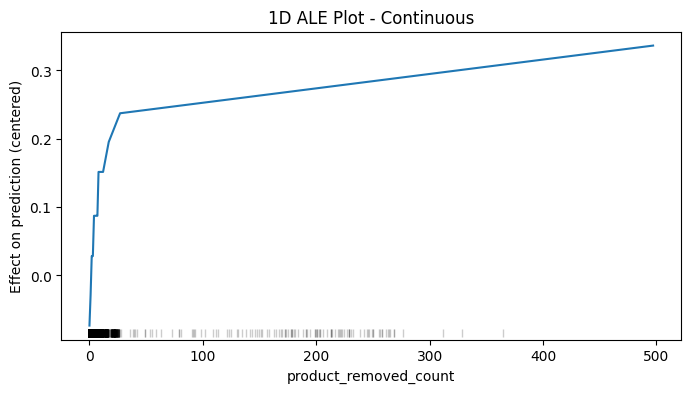

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5, feature 9


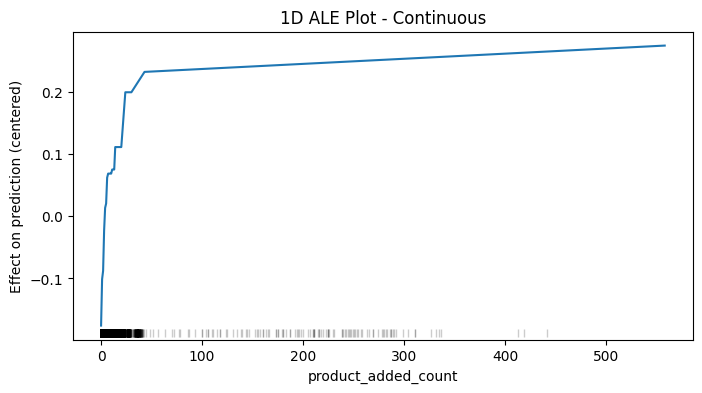

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5, feature 10


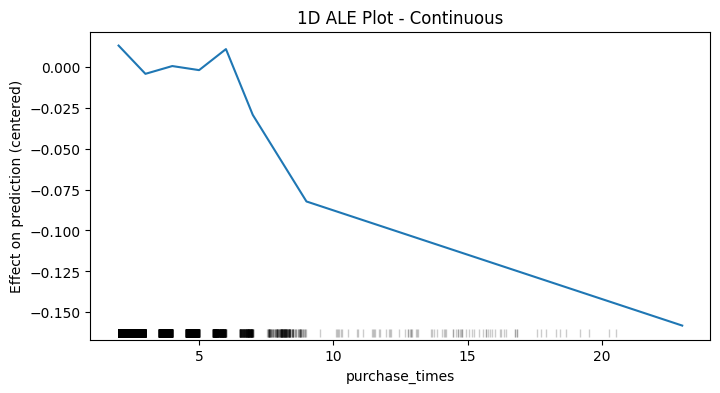

cluster 6's Cross Validation Accuracy: 0.8075390541707039


PyALE._ALE_generic:INFO: Continuous feature detected.


cluster 6's Confusion Matrix:
[[18328  6217]
 [ 3360 22228]]
cluster 6's Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.79     24545
         1.0       0.78      0.87      0.82     25588

    accuracy                           0.81     50133
   macro avg       0.81      0.81      0.81     50133
weighted avg       0.81      0.81      0.81     50133

cluster 6's Accuracy: 0.8089681447350049 

cluster 6's Computation Time: 218.99491453170776 

ALE plot for Cluster 6, feature 1


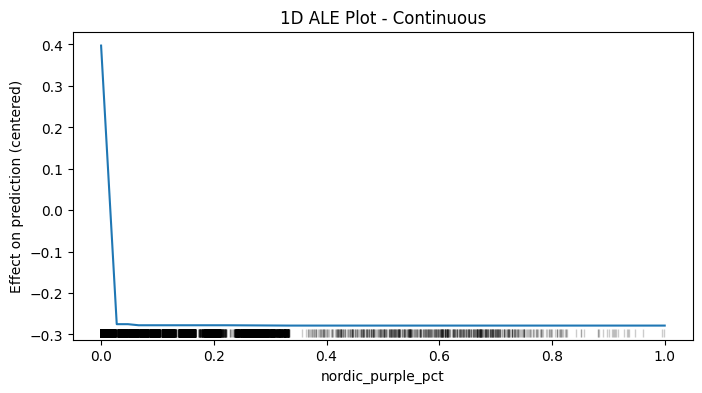

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6, feature 2


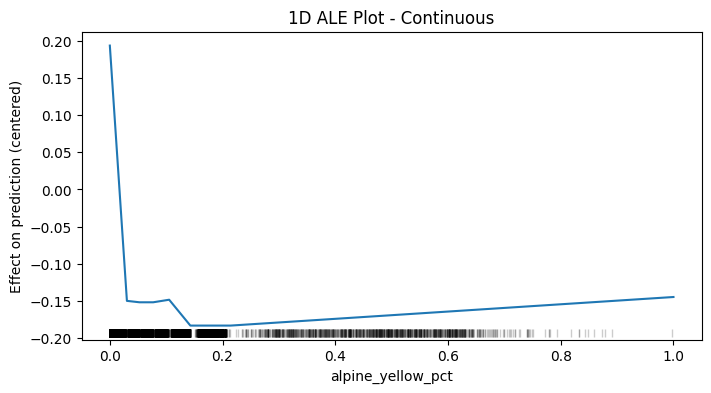

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6, feature 3


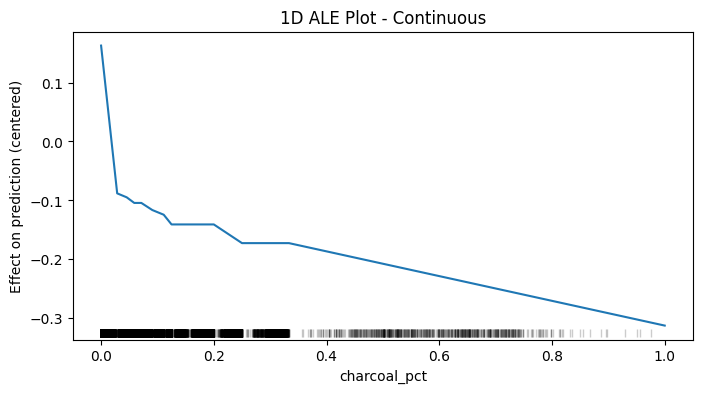

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6, feature 4


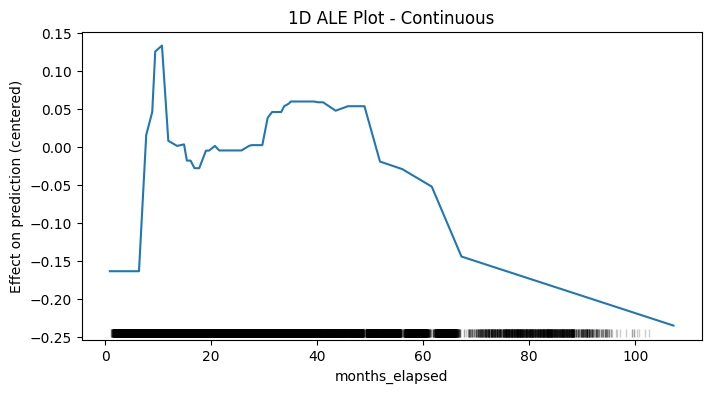

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6, feature 5


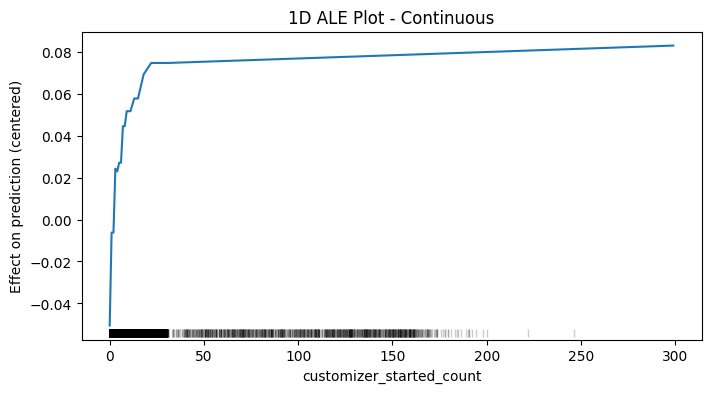

PyALE._ALE_generic:INFO: Discrete feature detected.


ALE plot for Cluster 6, feature 6


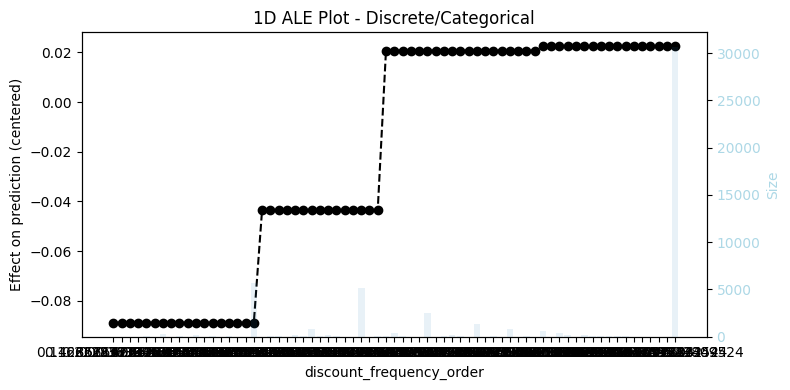

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6, feature 7


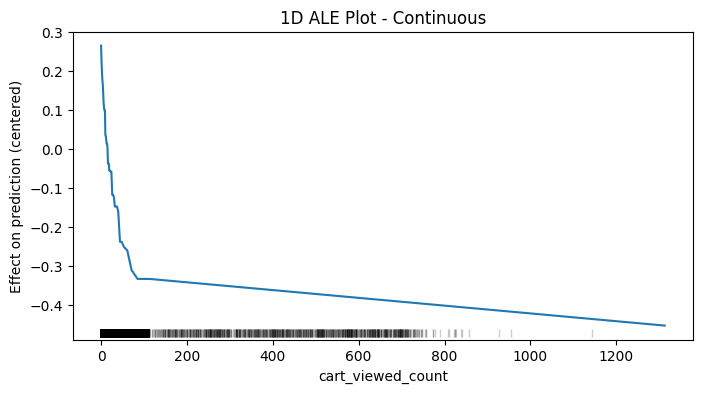

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6, feature 8


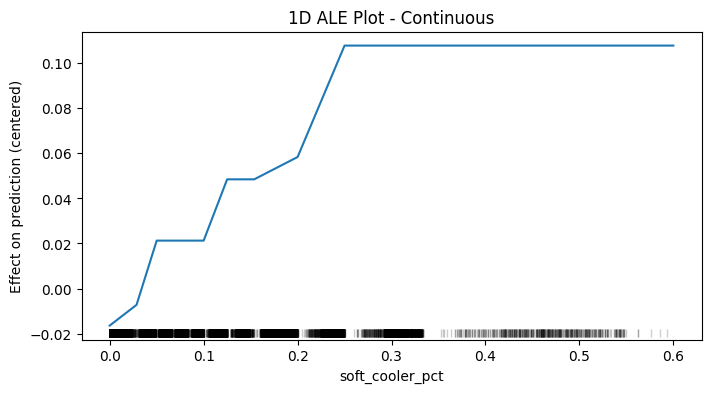

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6, feature 9


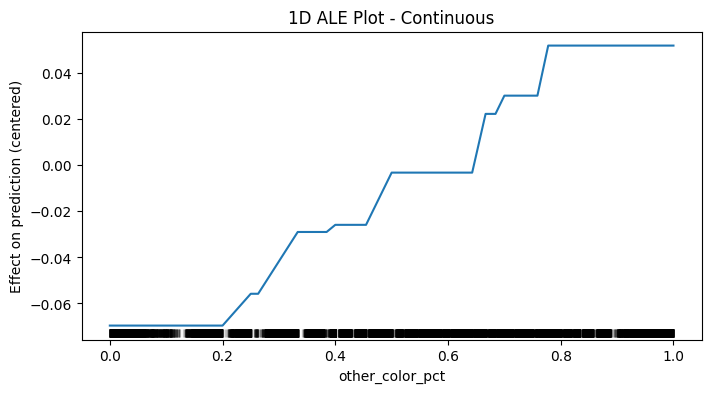

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6, feature 10


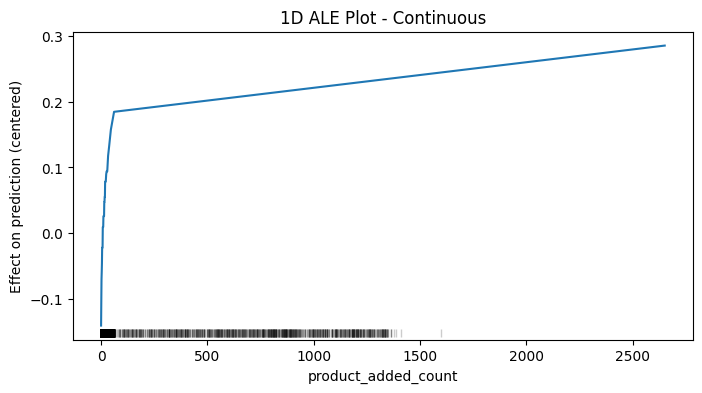

cluster 7's Cross Validation Accuracy: 0.8208542635712293


PyALE._ALE_generic:INFO: Continuous feature detected.


cluster 7's Confusion Matrix:
[[1059  303]
 [ 176 1320]]
cluster 7's Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82      1362
         1.0       0.81      0.88      0.85      1496

    accuracy                           0.83      2858
   macro avg       0.84      0.83      0.83      2858
weighted avg       0.83      0.83      0.83      2858

cluster 7's Accuracy: 0.8324002799160252 

cluster 7's Computation Time: 5.7558064460754395 

ALE plot for Cluster 7, feature 1


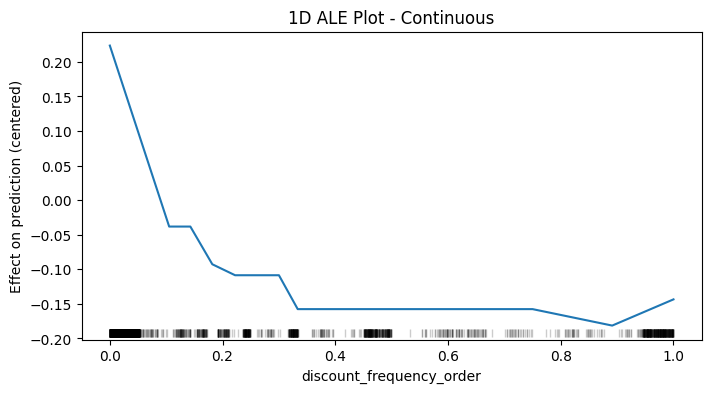

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 2


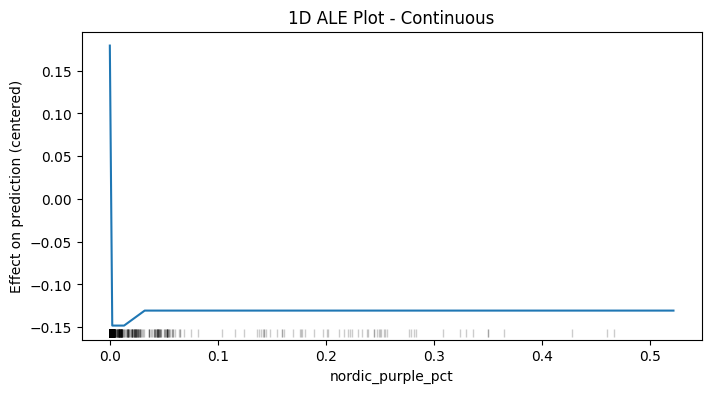

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 3


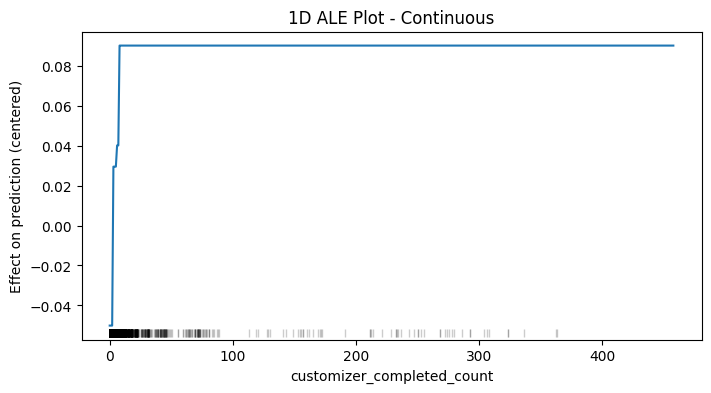

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 4


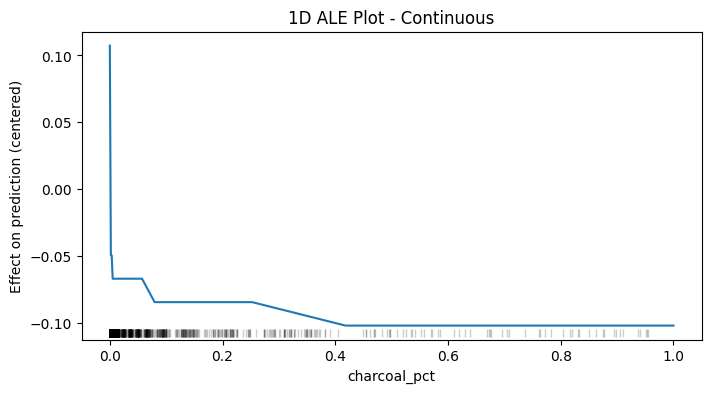

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 5


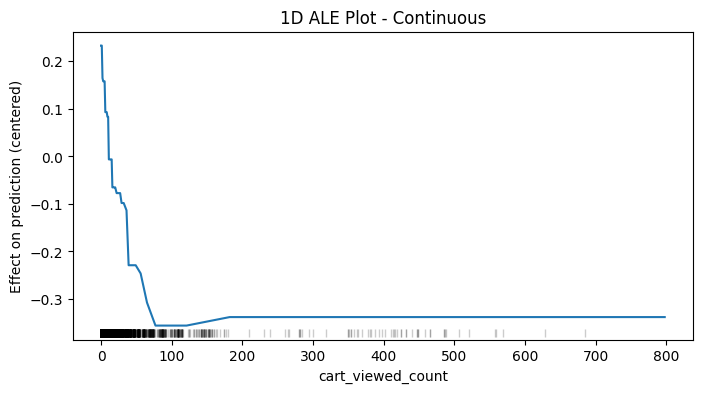

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 6


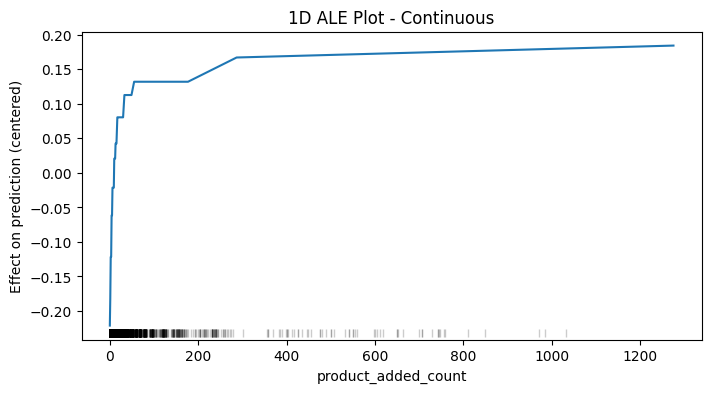

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 7


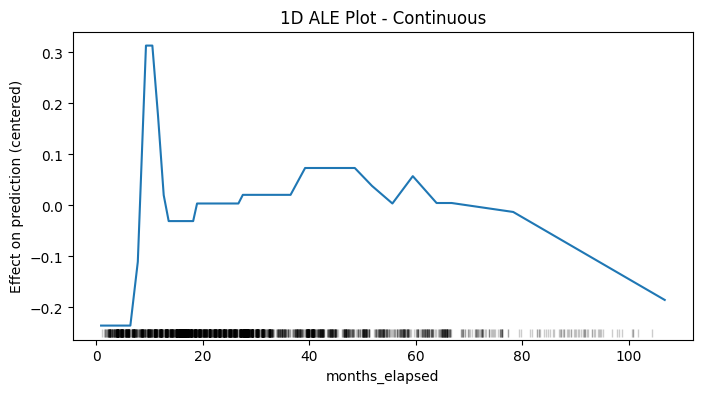

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 8


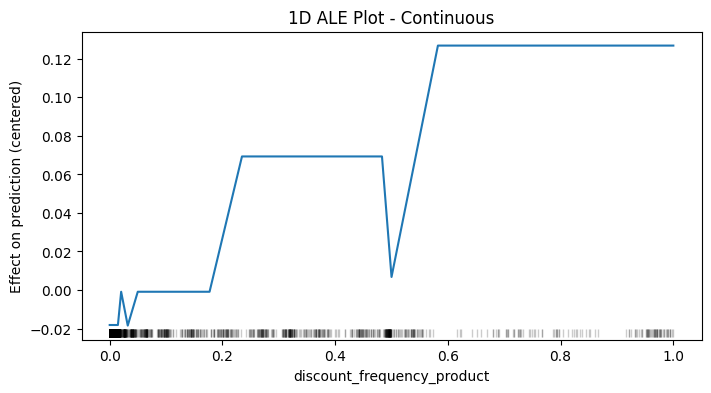

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 9


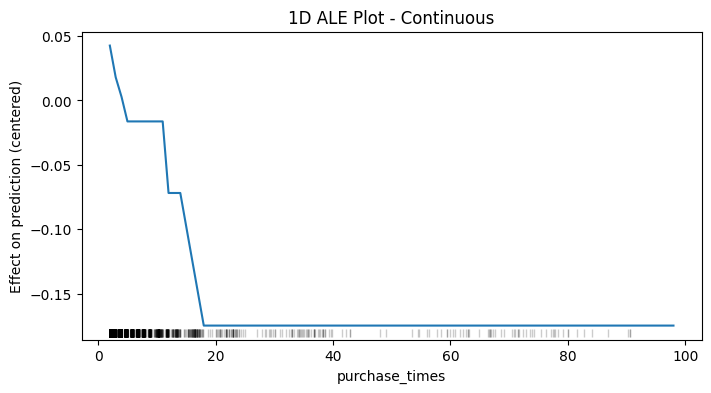

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7, feature 10


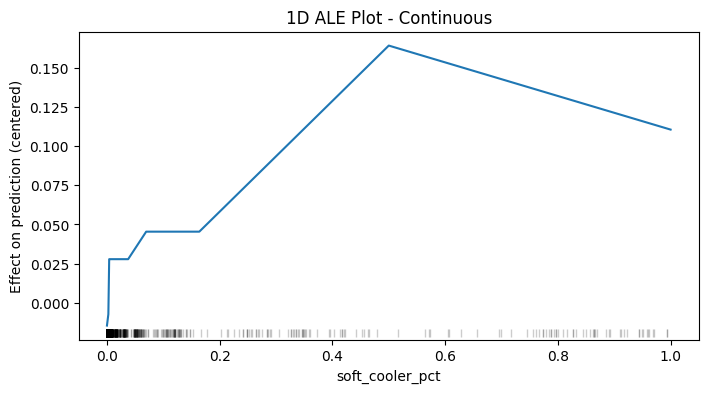

In [9]:
xgb_accuracy_scores = []
xgb_churn_prob = []
xgb_cv = []

# create an empty dataframe to store the computation time
Xgb_time=pd.DataFrame(columns=["Cluster","Time"])

# create an empty dataframe to store the feature importance scores
feature_importance_df = pd.DataFrame(columns=['Cluster', 'Feature', 'Importance'])

for i in range(0, 8):
    start_time = time.time() # Start the timer
    df_xgb = globals()['df_cluster_short{}'.format(i)]
    df_xgb=df_xgb.drop(['avg_time_btw_orders', 'recency'],axis=1)
    
    # create a new DataFrame for the noise column
    noise_df = pd.DataFrame(np.random.rand(len(df_xgb)), index=df_xgb.index, columns=["noise"])


    # concatenate the noise DataFrame with your feature matrix
    df_xgb = pd.concat([df_xgb, noise_df], axis=1)

    y_data=df_xgb.churn
    x_data=df_xgb.drop(['churn'],axis=1)
    
    
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state = 42
                                                       )
    
    Xgb_clf = xgb.XGBClassifier(max_depth=2,n_estimators=150,learning_rate=0.5)
    
    
    # Cross-validation
    cv_results = cross_validate(Xgb_clf, X_train, y_train, cv=5, scoring='accuracy')
    cv_accuracy = cv_results['test_score']
    print("cluster {}'s Cross Validation Accuracy:".format(i), cv_accuracy.mean())
    
    
    Xgb_clf.fit(X_train, y_train)
    
    ypred=Xgb_clf.predict(X_test) #These are the predicted output values
    
    # Get the feature importance scores for testing sets!!!!
    feature_importances = Xgb_clf.feature_importances_

    # add the feature importance scores to the dataframe
    for j in range(len(feature_importances)):
        feature_importance_df = feature_importance_df.append({'Cluster': i, 'Feature': x_data.columns[j], 'Importance': feature_importances[j]}, ignore_index=True)

    
    result = confusion_matrix(y_test, ypred)
    end_time = time.time() # End the timer
    print("cluster {}'s Confusion Matrix:".format(i))
    print(result)

    result1 = classification_report(y_test, ypred)
    print("cluster {}'s Classification Report:".format(i))
    print (result1)

    result2 = accuracy_score(y_test,ypred)
    print("cluster {}'s Accuracy:".format(i),result2,"\n")
    

    time_lapse=end_time - start_time
    Xgb_time.loc[i]=[i,time_lapse]

    print("cluster {}'s Computation Time:".format(i),time_lapse, "\n") # Print the computation time
    
    sorted_indices = np.argsort(feature_importances)[::-1]

    # Get the top 10 features and run ALE plot
    top_3_features = x_data.columns[sorted_indices][:10]


    k=1
    for feature_name in top_3_features:
        print(f'ALE plot for Cluster {i}, feature {k}')
        ale_eff = ale(X=X_test, model=Xgb_clf, feature=[feature_name], 
              grid_size=50, include_CI=False)

        # Display the plot
        plt.show()
        k=k+1
    churn_pred_percent = np.sum(ypred == 1) / len(y_test) * 100
    xgb_accuracy_scores.append(result2)
    xgb_churn_prob.append(churn_pred_percent)
    xgb_cv.append(cv_accuracy.mean())
    

In [47]:
clusters=pd.DataFrame(xgb_accuracy_scores,columns=["Model_Accuracy"])

In [48]:
clusters["Model_Churn_prob"]=xgb_churn_prob
clusters["Model_Churn_prob"]=clusters["Model_Churn_prob"]/100
clusters["Model_CV-Score"]=xgb_cv

clusters

Model_Accuracy  Model_Churn_prob  Model_CV-Score
0        0.760749          0.384397        0.762905
1        0.792520          0.643121        0.792580
2        0.804235          0.660677        0.803915
3        0.783430          0.588940        0.773139
4        0.803133          0.614380        0.801892
5        0.760408          0.617455        0.761131
6        0.808968          0.567391        0.807539
7        0.832400          0.567880        0.820854

In [ ]:
box=count_df.merge(clusters, left_index=True, right_index=True)
box1=box.round(2)
box1

Cluster No-Churn   Churn   Total Churn percentage  Model_Accuracy  \
0       0    44945   30874   75819         0.407207            0.76   
1       1    39773   55005   94778         0.580356            0.79   
2       2   166530  251700  418230         0.601822            0.80   
3       3    35404   41361   76765           0.5388            0.78   
4       4   239910  315842  555752         0.568315            0.80   
5       5    13134   16768   29902         0.560765            0.76   
6       6   123100  127562  250662           0.5089            0.81   
7       7     6837    7453   14290         0.521554            0.83   

   Model_Churn_prob  Model_CV-Score  
0              0.38            0.76  
1              0.64            0.79  
2              0.66            0.80  
3              0.59            0.77  
4              0.61            0.80  
5              0.62            0.76  
6              0.57            0.81  
7              0.57            0.82

In [ ]:
box

Cluster No-Churn   Churn   Total Churn percentage  Model_Accuracy  \
0       0    44945   30874   75819         0.407207        0.760749   
1       1    39773   55005   94778         0.580356        0.792520   
2       2   166530  251700  418230         0.601822        0.804235   
3       3    35404   41361   76765           0.5388        0.783430   
4       4   239910  315842  555752         0.568315        0.803133   
5       5    13134   16768   29902         0.560765        0.760408   
6       6   123100  127562  250662           0.5089        0.808968   
7       7     6837    7453   14290         0.521554        0.832400   

   Model_Churn_prob  Model_CV-Score  
0          0.384397        0.762905  
1          0.643121        0.792580  
2          0.660677        0.803915  
3          0.588940        0.773139  
4          0.614380        0.801892  
5          0.617455        0.761131  
6          0.567391        0.807539  
7          0.567880        0.820854

In [11]:
# pivot the feature_importance_df dataframe to a wide format
feature_importance_wide = feature_importance_df.pivot(index='Cluster', columns='Feature', values='Importance')
f_sort=feature_importance_wide.T
f_sort["Average"]=(feature_importance_wide.T[0]+feature_importance_wide.T[7]+feature_importance_wide.T[1]+feature_importance_wide.T[2]
                                    +feature_importance_wide.T[3]+feature_importance_wide.T[4]+feature_importance_wide.T[5]+feature_importance_wide.T[6])/7
f_sort=f_sort.sort_values("Average",ascending=False)

f_sort.style.format("{:.2f}").background_gradient(cmap='coolwarm')

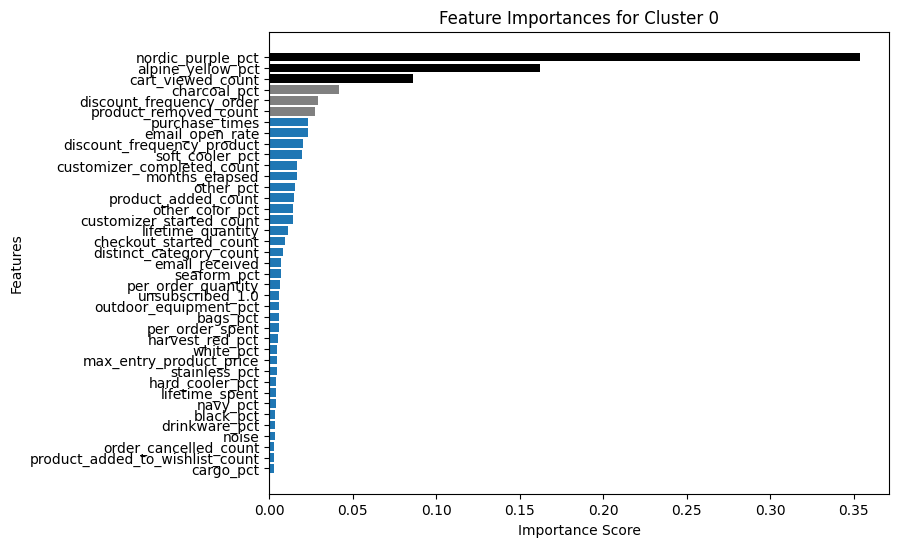

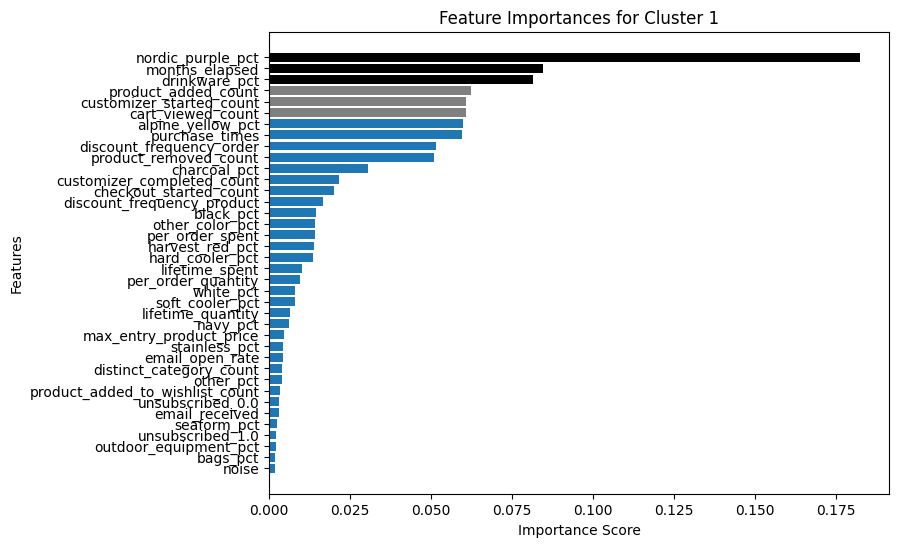

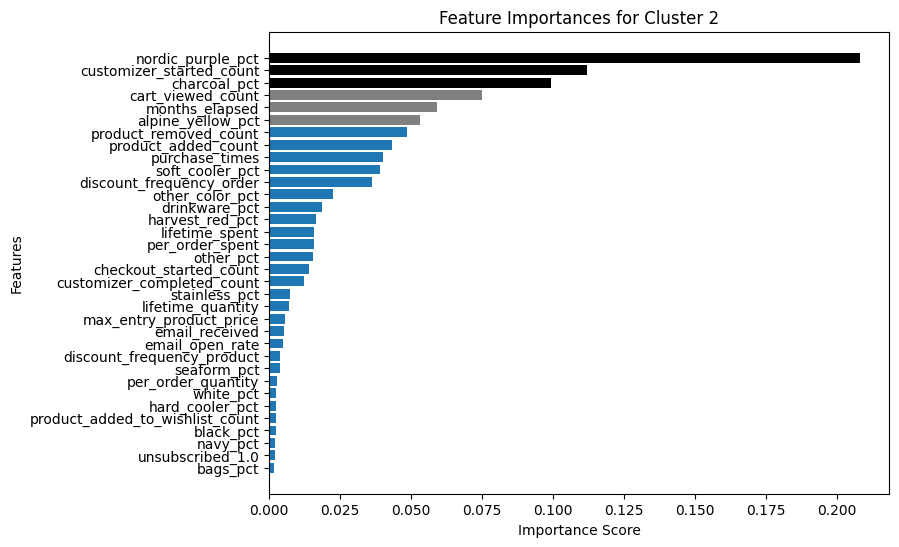

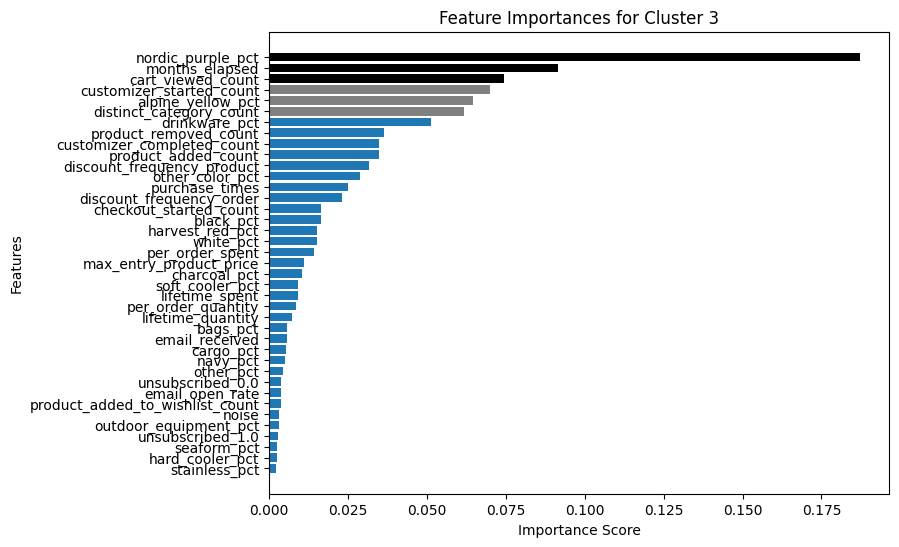

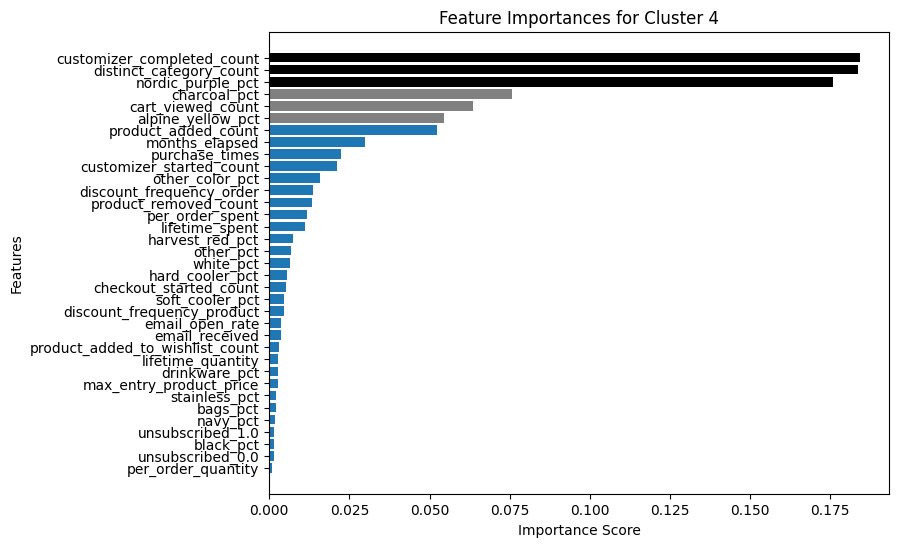

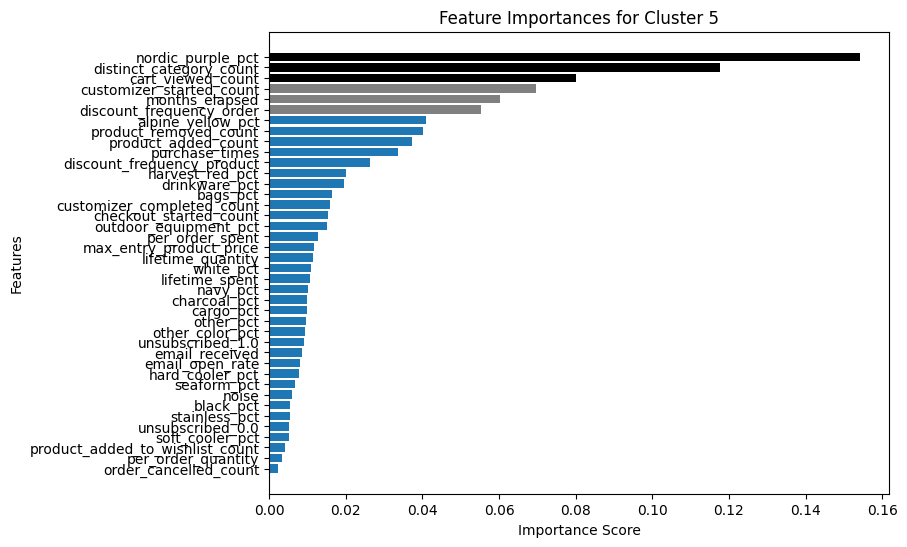

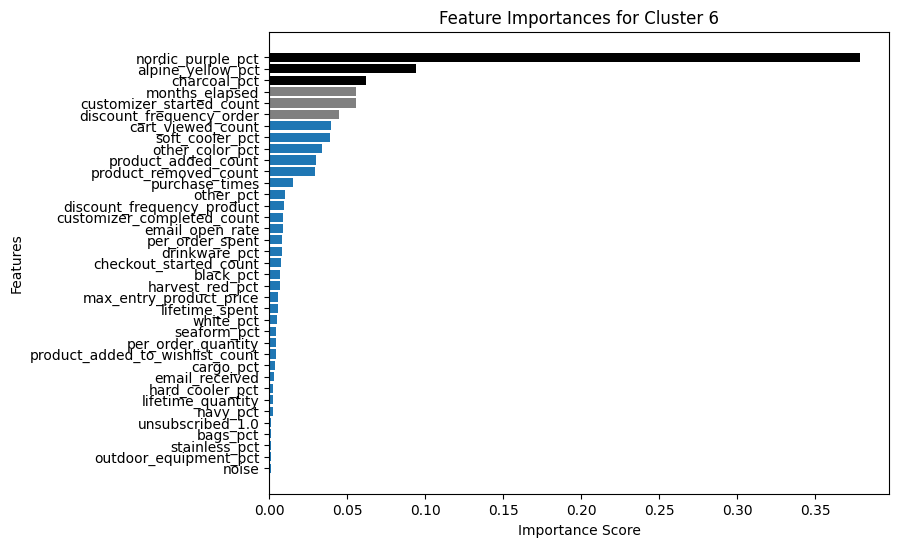

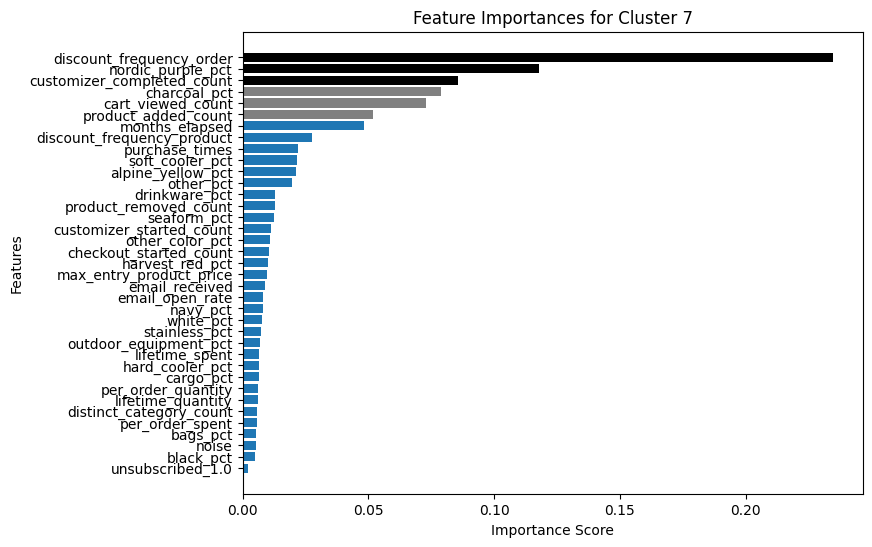

In [28]:
for i in range(len(feature_importance_wide)):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    values = feature_importance_wide.iloc[i, :]
    values_sorted = values.sort_values(ascending=True) # Sort by value in descending order
    nonzero_values = values_sorted[values_sorted != 0]
    sorted_idx = np.argsort(nonzero_values)[::-1]
    top3_idx = sorted_idx[:3]
    top6_idx = sorted_idx[3:6]
    
    ax.barh(nonzero_values.index, nonzero_values.values, label=f'Row {i}')
    
    # Mark the top 3 features with black bars
    for idx in top3_idx:
        ax.barh(nonzero_values.index[idx], nonzero_values.values[idx], color='black')
    
    # Mark the top 4-6 features with grey bars
    for idx in top6_idx:
        ax.barh(nonzero_values.index[idx], nonzero_values.values[idx], color='grey')
    
    # Set the plot title and labels
    ax.set_title(f'Feature Importances for Cluster {i}')
    ax.set_xlabel('Importance Score')
    ax.set_ylabel('Features')
    
    # Show the plot
    plt.show()

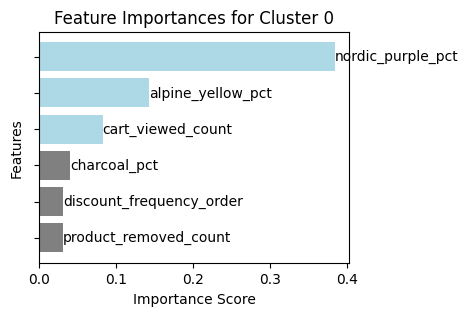

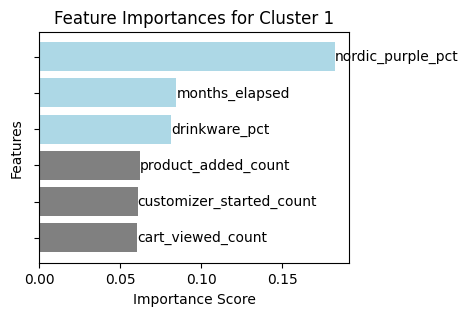

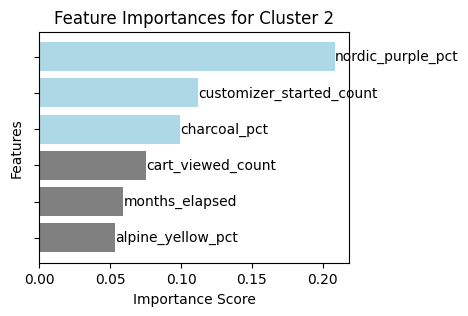

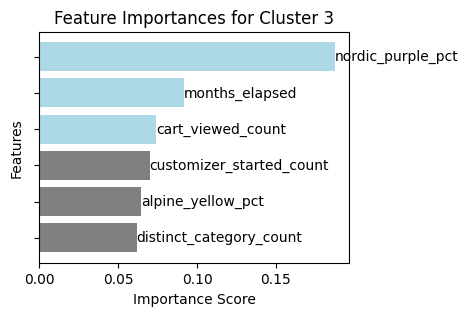

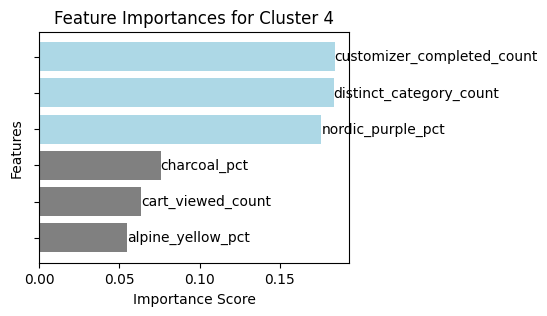

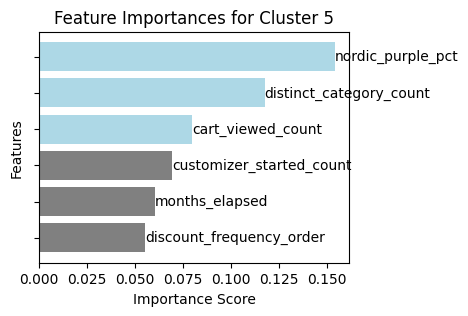

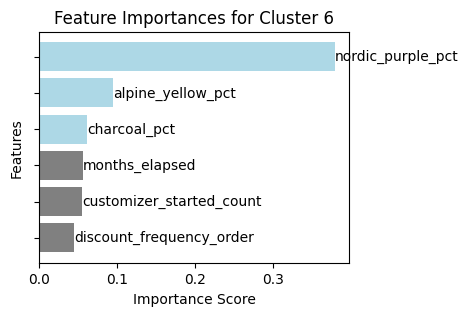

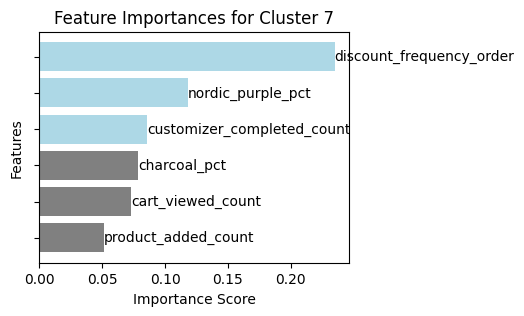

In [33]:
for i in range(len(feature_importance_wide)):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    values = feature_importance_wide.iloc[i, :]
    values_sorted = values.sort_values(ascending=False) # Sort by value in descending order
    nonzero_values = values_sorted[values_sorted != 0]
    sorted_idx = np.argsort(nonzero_values)[::-1]
    top3_idx = sorted_idx[:3][::-1]
    top6_idx = sorted_idx[:6][::-1]
    
    ax.barh(nonzero_values.index[top6_idx], nonzero_values.values[top6_idx], color='grey', label=f'Row {i}')
    ax.barh(nonzero_values.index[top3_idx], nonzero_values.values[top3_idx], color='lightblue')

    # Move y-axis labels inside the plot
    ax.set_yticklabels([])
    for j, feat in enumerate(nonzero_values.index[top6_idx]):
        ax.text(nonzero_values.values[top6_idx[j]], j, feat, ha='left', va='center')
    
    # Set the plot title and labels
    ax.set_title(f'Feature Importances for Cluster {i}')
    ax.set_xlabel('Importance Score')
    ax.set_ylabel('Features')
    
    # Show the plot
    plt.show()

#### Plotting ALE for nordic_purple feature in each cluster

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 0's nordic_purple feature


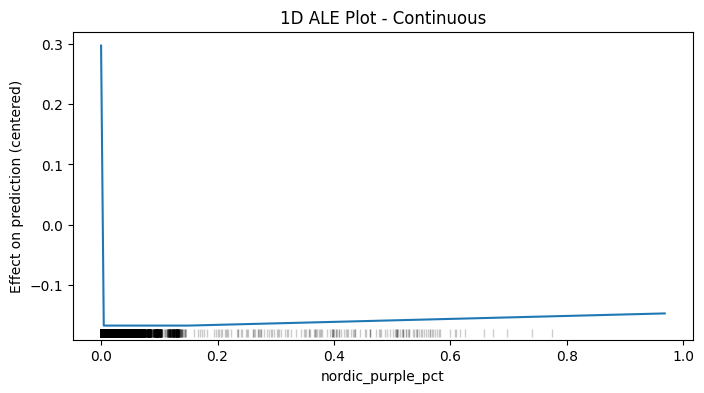

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 1's nordic_purple feature


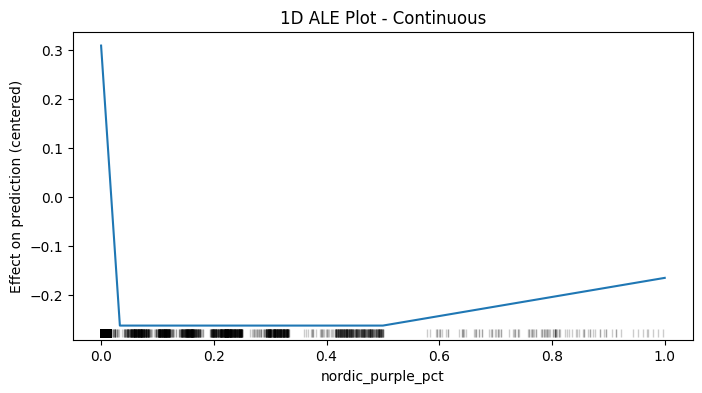

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 2's nordic_purple feature


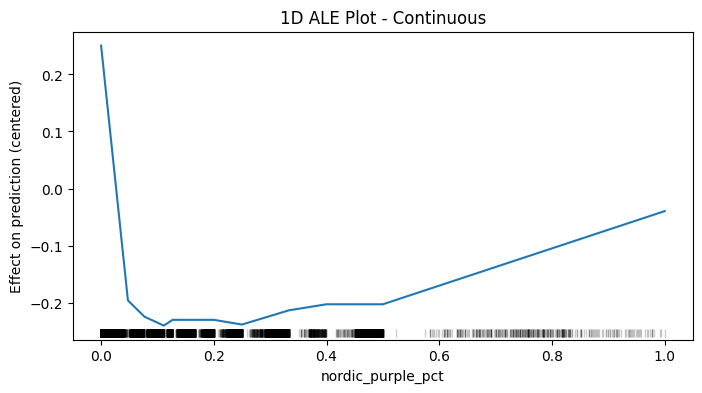

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 3's nordic_purple feature


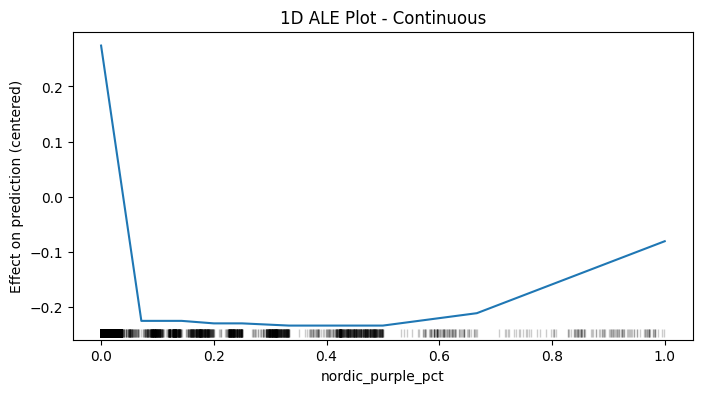

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 4's nordic_purple feature


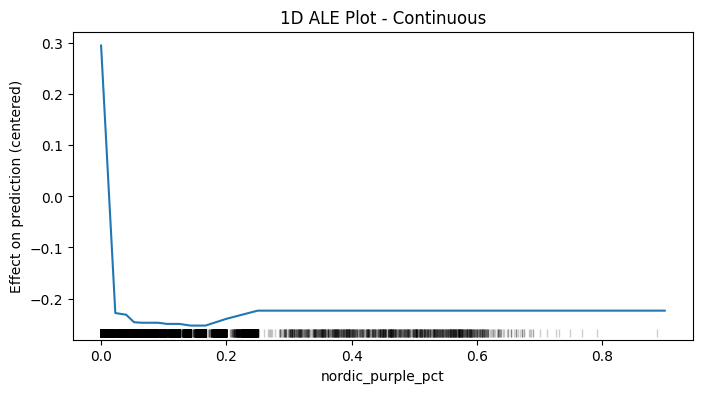

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 5's nordic_purple feature


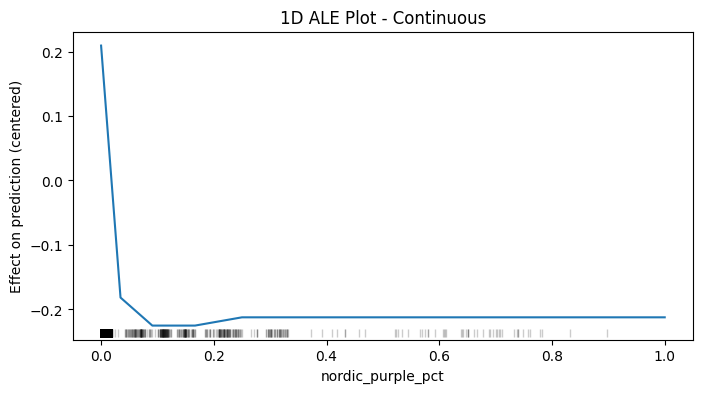

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 6's nordic_purple feature


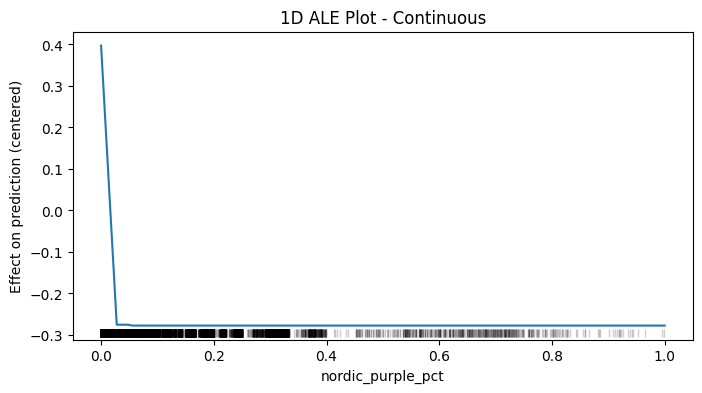

PyALE._ALE_generic:INFO: Continuous feature detected.


ALE plot for Cluster 7's nordic_purple feature


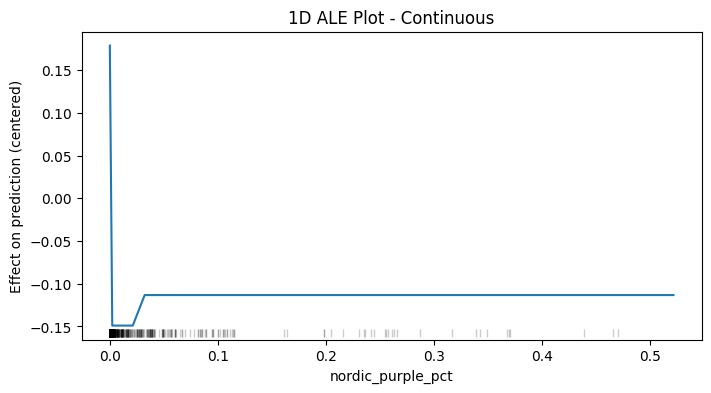

In [15]:

# create an empty dataframe to store the computation time
Xgb_time=pd.DataFrame(columns=["Cluster","Time"])

# create an empty dataframe to store the feature importance scores
feature_importance_df = pd.DataFrame(columns=['Cluster', 'Feature', 'Importance'])

for i in range(0, 8):
    start_time = time.time() # Start the timer
    df_xgb = globals()['df_cluster_short{}'.format(i)]
    df_xgb=df_xgb.drop(['avg_time_btw_orders', 'recency'],axis=1)
    
    # create a new DataFrame for the noise column
    noise_df = pd.DataFrame(np.random.rand(len(df_xgb)), index=df_xgb.index, columns=["noise"])


    # concatenate the noise DataFrame with your feature matrix
    df_xgb = pd.concat([df_xgb, noise_df], axis=1)

    y_data=df_xgb.churn
    x_data=df_xgb.drop(['churn'],axis=1)
    
    
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.2, random_state = 42
                                                       )
    
    Xgb_clf = xgb.XGBClassifier(max_depth=2,n_estimators=150,learning_rate=0.5)
    
    
    # Cross-validation
    #cv_results = cross_validate(Ada_clf, X_train, y_train, cv=5, scoring='accuracy')
    #cv_accuracy = cv_results['test_score']
    #print("cluster {}'s Cross Validation Accuracy:".format(i), cv_accuracy.mean())
    
    
    Xgb_clf.fit(X_train, y_train)
    
    ypred=Xgb_clf.predict(X_test) #These are the predicted output values
    
    # Get the feature importance scores for testing sets!!!!
    feature_importances = Xgb_clf.feature_importances_

    # add the feature importance scores to the dataframe
    for j in range(len(feature_importances)):
        feature_importance_df = feature_importance_df.append({'Cluster': i, 'Feature': x_data.columns[j], 'Importance': feature_importances[j]}, ignore_index=True)

    
    result = confusion_matrix(y_test, ypred)
    end_time = time.time() # End the timer
    #print("cluster {}'s Confusion Matrix:".format(i))
    #print(result)

    result1 = classification_report(y_test, ypred)
    #print("cluster {}'s Classification Report:".format(i))
    #print (result1)

    result2 = accuracy_score(y_test,ypred)
    #print("cluster {}'s Accuracy:".format(i),result2,"\n")
    

    time_lapse=end_time - start_time
    Xgb_time.loc[i]=[i,time_lapse]

    #print("cluster {}'s Computation Time:".format(i),time_lapse, "\n") # Print the computation time
    
    sorted_indices = np.argsort(feature_importances)[::-1]

    # Get the top 3 features and run ALE plot
    top_3_features = x_data.columns[sorted_indices][:3]


    
    print(f'ALE plot for Cluster {i}\'s nordic_purple feature' )
    ale_eff = ale(X=X_test, model=Xgb_clf, feature=['nordic_purple_pct'], 
              grid_size=100, include_CI=False)

    # Display the plot
    plt.show()

    

In [37]:
len(feature_importances)

41